In [1]:
import pandas as pd
import numpy as np
import os, glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from readers import read_and_merge_paths, read_json
import seaborn as sns

from collections import defaultdict
from matplotlib.ticker import MultipleLocator, PercentFormatter

# 
from plotting_utils import *
from metrics import compute_recall, compute_error_rate, compute_doc_provenance


# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif')

FULL_WIDTH = 6.75133
COL_WIDTH  = 3.25063

COMBINATIONS = (2, 3, 4, 5, 10)
MODELS = (
    "accounts/fireworks/models/llama-v3p1-70b-instruct",
    "gpt-4o-2024-05-13",
    "gpt-3.5-turbo-0125",
    "accounts/fireworks/models/qwen2-72b-instruct",
    "gemini-1.5-flash",
)

PROMPT_SETTING = (
    "subtopic",
    "subtopic_trustworthy",
)

## Load results

In this section, we load the results from the `run_final_postprocessing` step, which creates a file w/ all the labels for the different metrics, including:

- `ref_coverage_*`: concerns the use of LLM as a judge to determine the coverage of each reference. This results in a 1 to many mapping, where different predicted insights can be covering the same reference insight.
- `pred_coverage_*`: concerns the use of LLM as a judge to determine the coverage of each predicted insight. This results in a 1 to many mapping, where different reference insights can be covering the same predicted insight.
- `bidirectional`: concerns the use of LLM as a judge to determine the coverage of each reference and also vice-versa. Intuitively it merges the `ref_coverage_*` and `pred_coverage_*` labels by keeping labels for reference and predicted insights whose coverage match among the two runs. The final label is determined as the lowest coverage possible of the two.

In [103]:
metric = "bidirectional"
domain = "conv"
base_dir = f"../outputs_{domain}/run_final_postprocessing-multi-request/gpt-4o-mini-2024-07-18/results_some_shared"

max_rank = None # "num_refs" # 2
all_recall_results = []
all_err_rate_results = []
for model in MODELS:
    for prompt in PROMPT_SETTING:
        for combination in COMBINATIONS:
            filepaths = sorted(glob.glob(f"{base_dir}/{prompt}/SummHay__combinations-{combination}/{model}/{metric}__*.json"))            
            for filepath in filepaths: 
                data = read_json(filepath)
                recall = compute_recall(data["labels"],
                                        ref_is_queried_subtopic=True,
                                        ref_is_shared=(prompt == "subtopic_trustworthy"),
                                        max_rank=max_rank)

                err_rate = compute_error_rate(data["labels"],
                                        ref_is_queried_subtopic=True,
                                        ref_is_shared=(prompt == "subtopic_trustworthy"),
                                        max_rank=max_rank,
                                        metric_name=metric,
                )
                
                for df in (recall, err_rate):
                    df["summarizer_model"] = model.rpartition("/")[-1]
                    df["prompt"] = prompt
                    df["num_documents"] = combination
                    df["metric"] = metric
                    df["filepath"] = filepath.rpartition(metric + "__")[-1]

                all_recall_results.append(recall)
                all_err_rate_results.append(err_rate)

all_recall_results = pd.concat(all_recall_results)
all_err_rate_results = pd.concat(all_err_rate_results)
assert len(all_recall_results) == len(all_err_rate_results)

# -----------------------------------------------------------------
# Compute F1 Scores
# -----------------------------------------------------------------
MERGING_COLS = ["filepath", "response_id", "label_type", "num_documents", "summarizer_model", "prompt"]
all_f1_results = all_recall_results.set_index(MERGING_COLS)
all_f1_results = all_f1_results.join(all_err_rate_results.set_index(MERGING_COLS), how="inner", lsuffix="_recall", rsuffix="_err_rate")
all_f1_results = all_f1_results.reset_index()
all_f1_results["fraction_precision"] = 1 - all_f1_results["fraction_err_rate"]
assert len(all_f1_results) == len(all_err_rate_results)

def f_beta_score(values, beta=1):
    """By default it computes f1 score, which assumes equal importance
    between recall and precision. If recall is 2x more important than
    precision, then set `beta=2`."""
    recall, precision = values["fraction_recall"], values["fraction_precision"]
    fac1 = (1 + beta*beta)
    fac2_num = precision*recall
    fac2_den = (beta*beta) * precision + recall
    if fac2_den == 0:
        return 0
        
    return fac1 * fac2_num / fac2_den

all_f1_results["f1_score"] = all_f1_results[["fraction_recall", "fraction_precision"]].apply(f_beta_score, axis=1)

Each file will be constitute the following keys:
- documents: all documents and their metadata.
- input_filepath: the evaluation filepath from which the labels were derived
- insights: all insights and their metadata.
- metric: the name of the metric.
- subtopics: all subtopics and their metadata.
- topics: the topic name.
- topic_id: the topic unique identifier.
- labels: the labels according to the evaluation metric. We will have one label for each predicted insight and reference insight. In cases, where the reference insight (or predicted insight) has no match, we will encounter a label `NO_COVERAGE`.
    - `coverage`: the coverage label among `PARTIAL_COVERAGE`, `FULL_COVERAGE`, and `NO_COVERAGE`.
    - `docs_uuids_ordered`: the ordered list of document uuid. The first element in this list concerns the unique identifier of the document that was placed first in the prompt.
    - `num_preds`: number of predicted insights from the model.
    - `num_refs_in_context`: total number of reference insights in the context.
    - `pred_uuid`: the unique identifier of the predicted insight.
    - `pred_text`: the text of the predicted insight
    - `pred_rank`: the rank of the predicted insight in the output. If it is 0, then it means it was the first bulletpoint in the summary.
    - `queried_subtopic`: the subtopic used to guide the summarization.
    - `queried_subtopic_uuid`: unique identifeir of the subtopic used to guide the summarization.
    - `ref_doc_attribution`: list of documents containing the reference insight. For combination of 2, this can either be [0, 1], [0], [1], or null.
    - `ref_is_queried_subtopic`: whether the reference insight belongs to the queried subtopic.
    - `ref_is_shared`: whether the reference insight is shared across 2+ documents.
    - `ref_num_shared`: number of documents containing the reference insight.
    - `ref_subtopic`: subtopic of the reference insight.
    - `ref_subtopic_uuid`: unique identifier of the subtopic of the reference insight.
    - `ref_text`: text of the reference insight.
    - `ref_uuid`: unique identifier of the reference insight.
    - `response_idx`: response identifier.


Here is an example of a label:
```
"coverage": "PARTIAL_COVERAGE",
      "docs_uuids_ordered": [
        "665693b3cfa5f926ed96ae33",
        "665693f6cfa5f926ed96ae59"
      ],
      "num_preds": 5,
      "num_refs_in_context": 5,
      "pred_rank": 4,
      "pred_text": "- The doctors acknowledged the wait times involved in seeing a specialist and informed the patients about the estimated wait time for an appointment.",
      "pred_uuid": "fa59f6894d26c34609b107f8ff2823f1",
      "queried_subtopic": "discussion about ordering or reviewing lab tests for better diagnosis",
      "queried_subtopic_uuid": "665692f3cfa5f926ed96adc0",
      "ref_doc_attribution": [
        0,
        1
      ],
      "ref_is_queried_subtopic": true,
      "ref_is_shared": true,
      "ref_num_shared": 2,
      "ref_subtopic": "doctor discussing the possibility of referring the patient to a specialist",
      "ref_subtopic_uuid": "665692f3cfa5f926ed96adc1",
      "ref_text": "The doctor discusses potential wait times for specialist appointments and mentions that it could take approximately 3-4 weeks to get an appointment with the recommended specialist.",
      "ref_uuid": "6656931dcfa5f926ed96ade9",
      "response_idx": 0
```

## Summary Statistics

Image saved in ../paper-oct/images/conv__bidirectional__num_insights__both_prompts__None.pdf


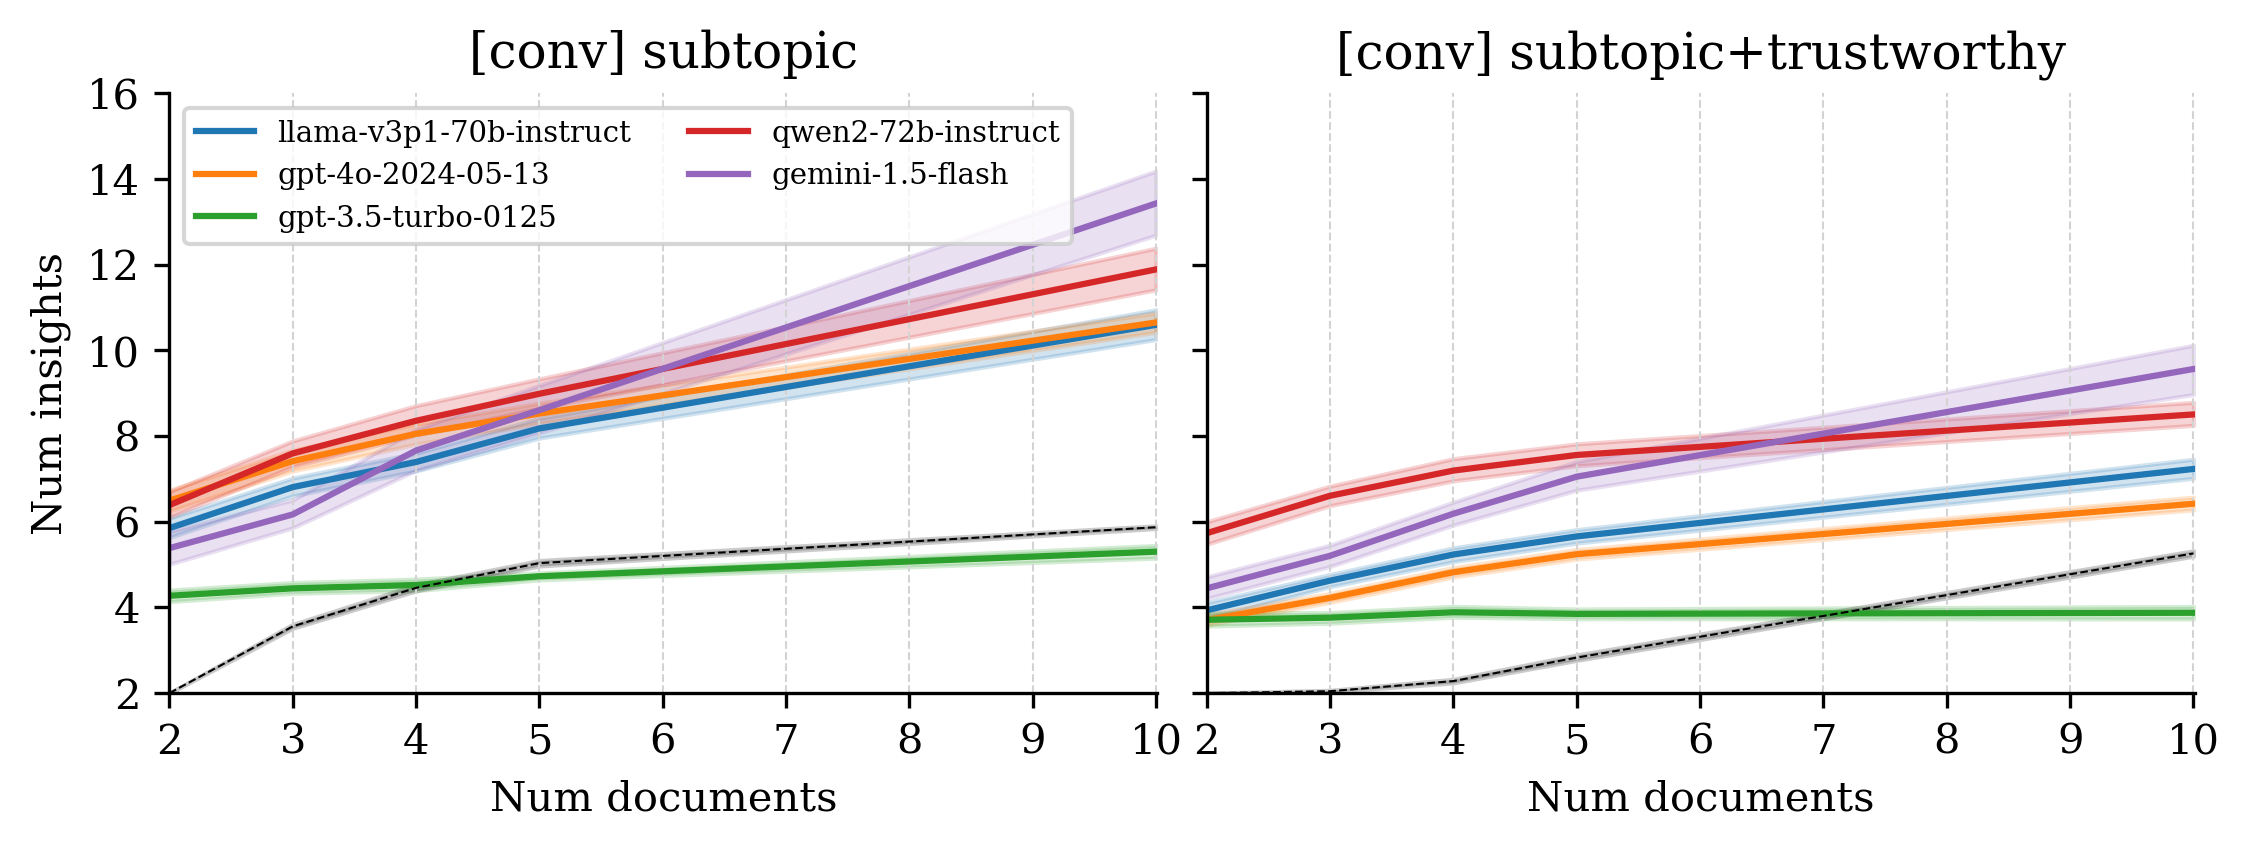

In [104]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)

subset_recall = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc") 
    & (all_recall_results["summarizer_model"] == "llama-v3p1-70b-instruct")
    & (all_recall_results["prompt"] == "subtopic")
]

ax = axes[0]
subset_err = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == "subtopic")
]
ax.set_title(f"[{domain}] subtopic")
sns.lineplot(subset_err, x="num_documents", y="n", hue="summarizer_model", ax=ax)
sns.lineplot(subset_recall, x="num_documents", y="n", ax=ax, color="black", linewidth=0.5, linestyle='--')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Num insights")

ax.set_xlim((2, 10.01))
ax.legend(loc="upper left", ncols=2, bbox_to_anchor=(0.0, 1), fontsize=7)

remove_axes(ax)

ax = axes[1]
subset_shared_err = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == "subtopic_trustworthy")
]

subset_shared_recall = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc") 
    & (all_recall_results["summarizer_model"] == "llama-v3p1-70b-instruct")
    & (all_recall_results["prompt"] == "subtopic_trustworthy")
]
ax.set_title(f"[{domain}] subtopic+trustworthy")
sns.lineplot(subset_shared_err, x="num_documents", y="n", hue="summarizer_model", ax=ax)
sns.lineplot(subset_shared_recall, x="num_documents", y="n", ax=ax, color="black", linewidth=0.5, linestyle='--')
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Num Insights")

ax.set_xlim((2, 10.01))
ax.set_ylim(2, 16)
remove_axes(ax)
ax.get_legend().remove()

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}__{metric}__num_insights__both_prompts__{max_rank}.pdf", dpi=300)

llama-v3p1-70b-instruct 500
llama-v3p1-70b-instruct 500
gpt-4o-2024-05-13 500
gpt-4o-2024-05-13 500
gpt-3.5-turbo-0125 500
gpt-3.5-turbo-0125 500
qwen2-72b-instruct 500
qwen2-72b-instruct 500
gemini-1.5-flash 500
gemini-1.5-flash 500
Image saved in ../paper-oct/images/conv__bidirectional__10__pred_insights_dist__both_prompts.pdf


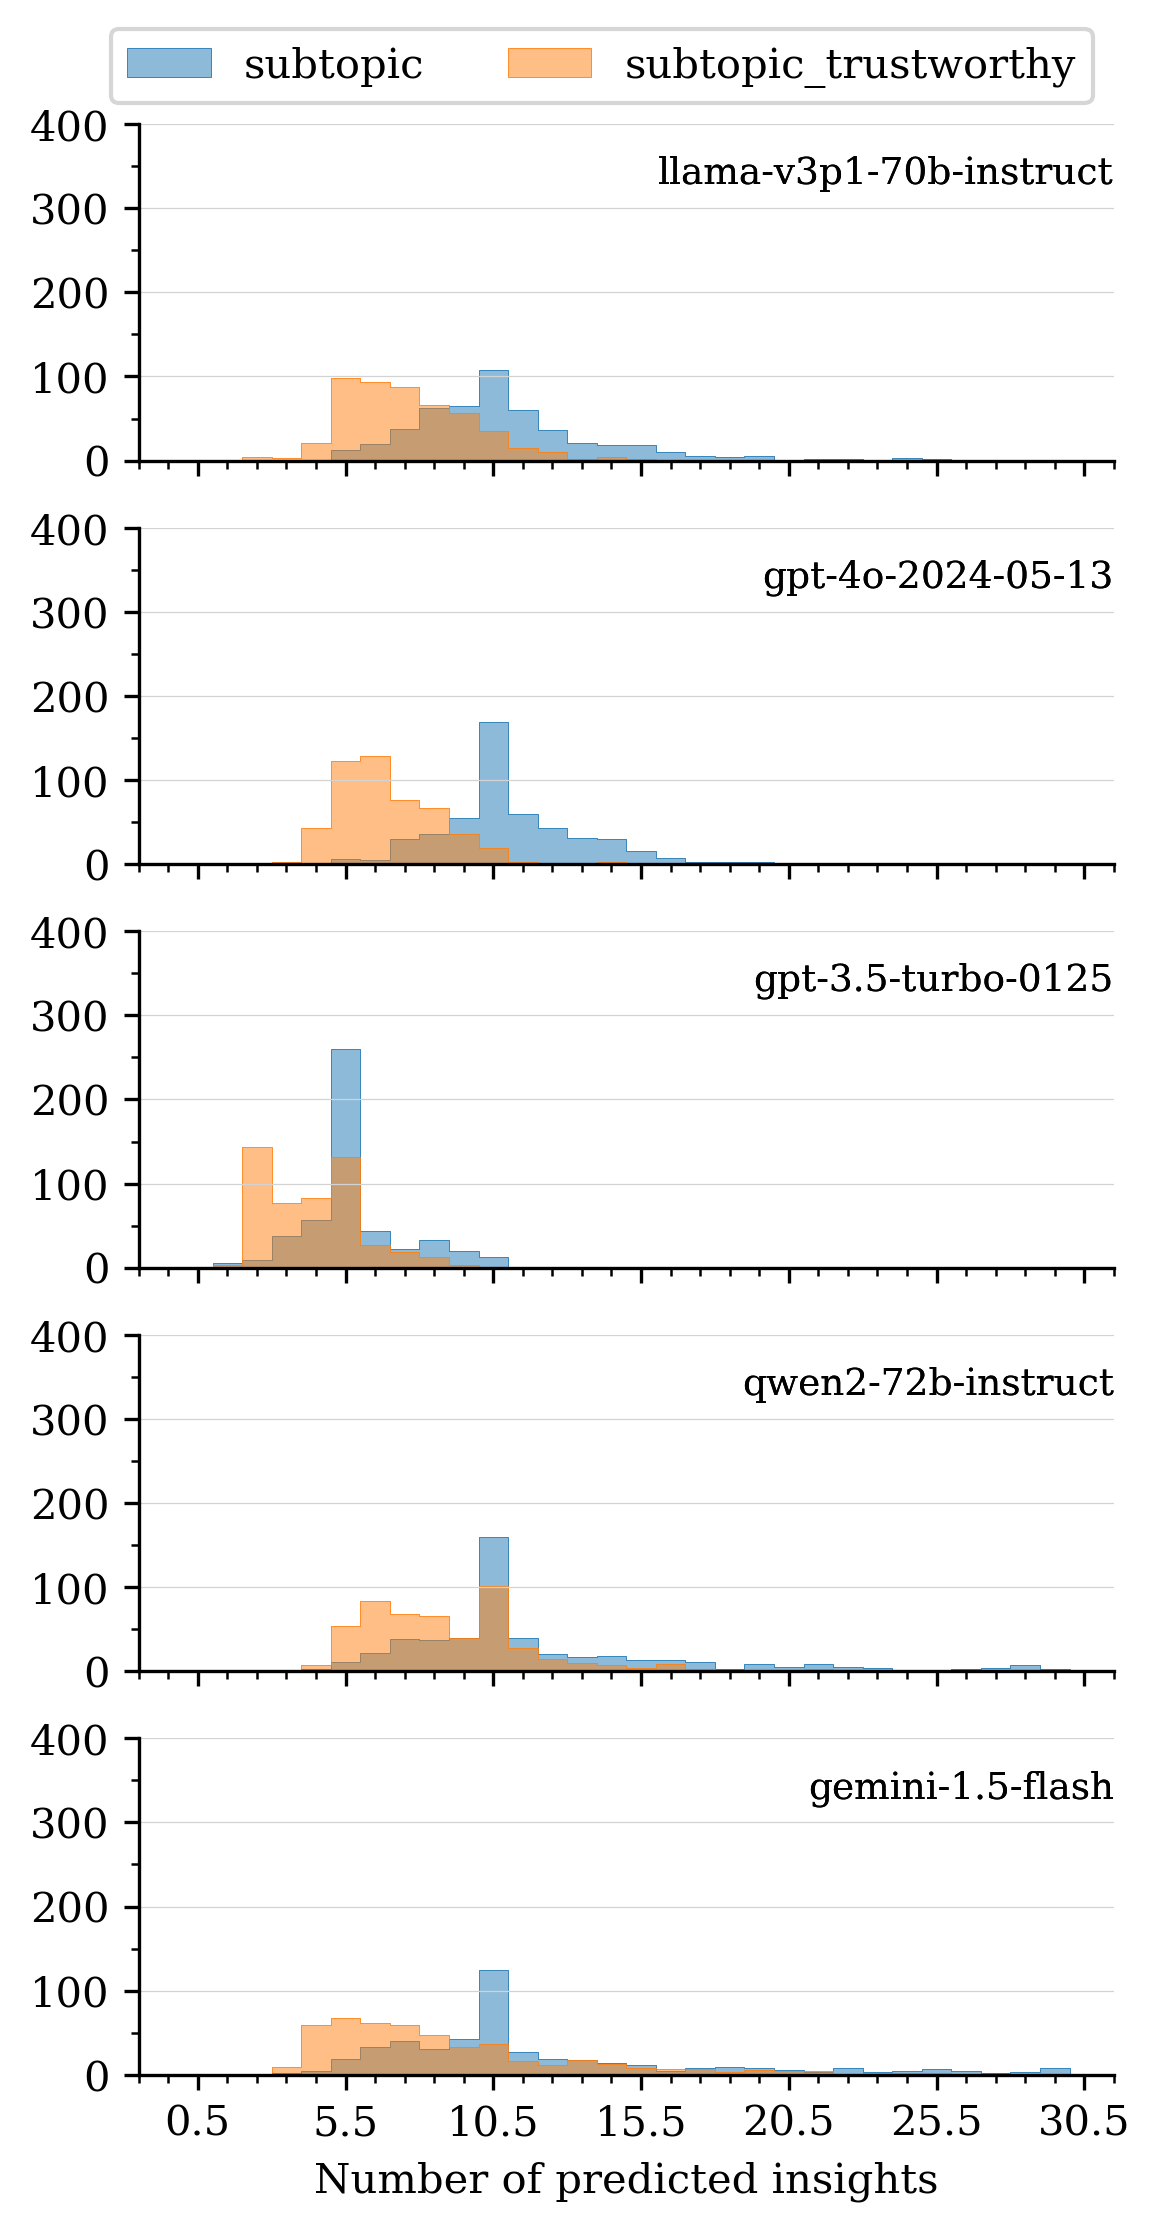

In [105]:
combination=10
_subset = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["num_documents"] == combination)
]

fig, axes = plt.subplots(len(MODELS), 1, sharex=True, figsize=(COL_WIDTH, COL_WIDTH*2), dpi=300)

for ax, model in zip(axes, MODELS):
    model_name = model.rpartition("/")[-1]
    _subset_model = _subset[_subset["summarizer_model"] == model_name].copy()
    
    for prompt in PROMPT_SETTING:
        print(model_name, len(_subset_model[_subset_model["prompt"]==prompt]))
        sns.histplot(_subset_model[_subset_model["prompt"]==prompt], x="n", label=prompt, ax=ax, binrange=(0, 30), binwidth=1, element="step", alpha=0.5, lw=0.2)
        ax.text(1.0, 0.80, model_name, fontsize=9, transform=ax.transAxes, ha='right', va='bottom')
        
        ax.xaxis.set_minor_locator(MultipleLocator(1, offset=0.5))
        ax.xaxis.set_major_locator(MultipleLocator(5, offset=0.5))
        ax.yaxis.set_minor_locator(MultipleLocator(50))
        ax.yaxis.set_major_locator(MultipleLocator(100))
        # ax.yaxis.set_major_formatter(PercentFormatter(1.0, symbol="", decimals=0))
        
        ax.grid(axis='y', which="major", linewidth=0.3, linestyle='-', color="lightgray")
        # ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")
        
        ax.set_xlabel("Number of predicted insights")
        ax.set_ylabel(None)
        ax.set_ylim(0, 400)
    
    remove_axes(ax)
    if model == MODELS[0]:
        ax.legend(loc="lower left", ncols=2, bbox_to_anchor=(-0.05,1), fontsize=10)
    # else:
        # ax.get_legend().remove()

adjust(fig, hspace=0.2)
save_fig(fig, f"{domain}__{metric}__{combination}__pred_insights_dist__both_prompts.pdf", dpi=300)

Image saved in ../paper-oct/images/conv__bidirectional__num_insights__both_prompts__None.pdf


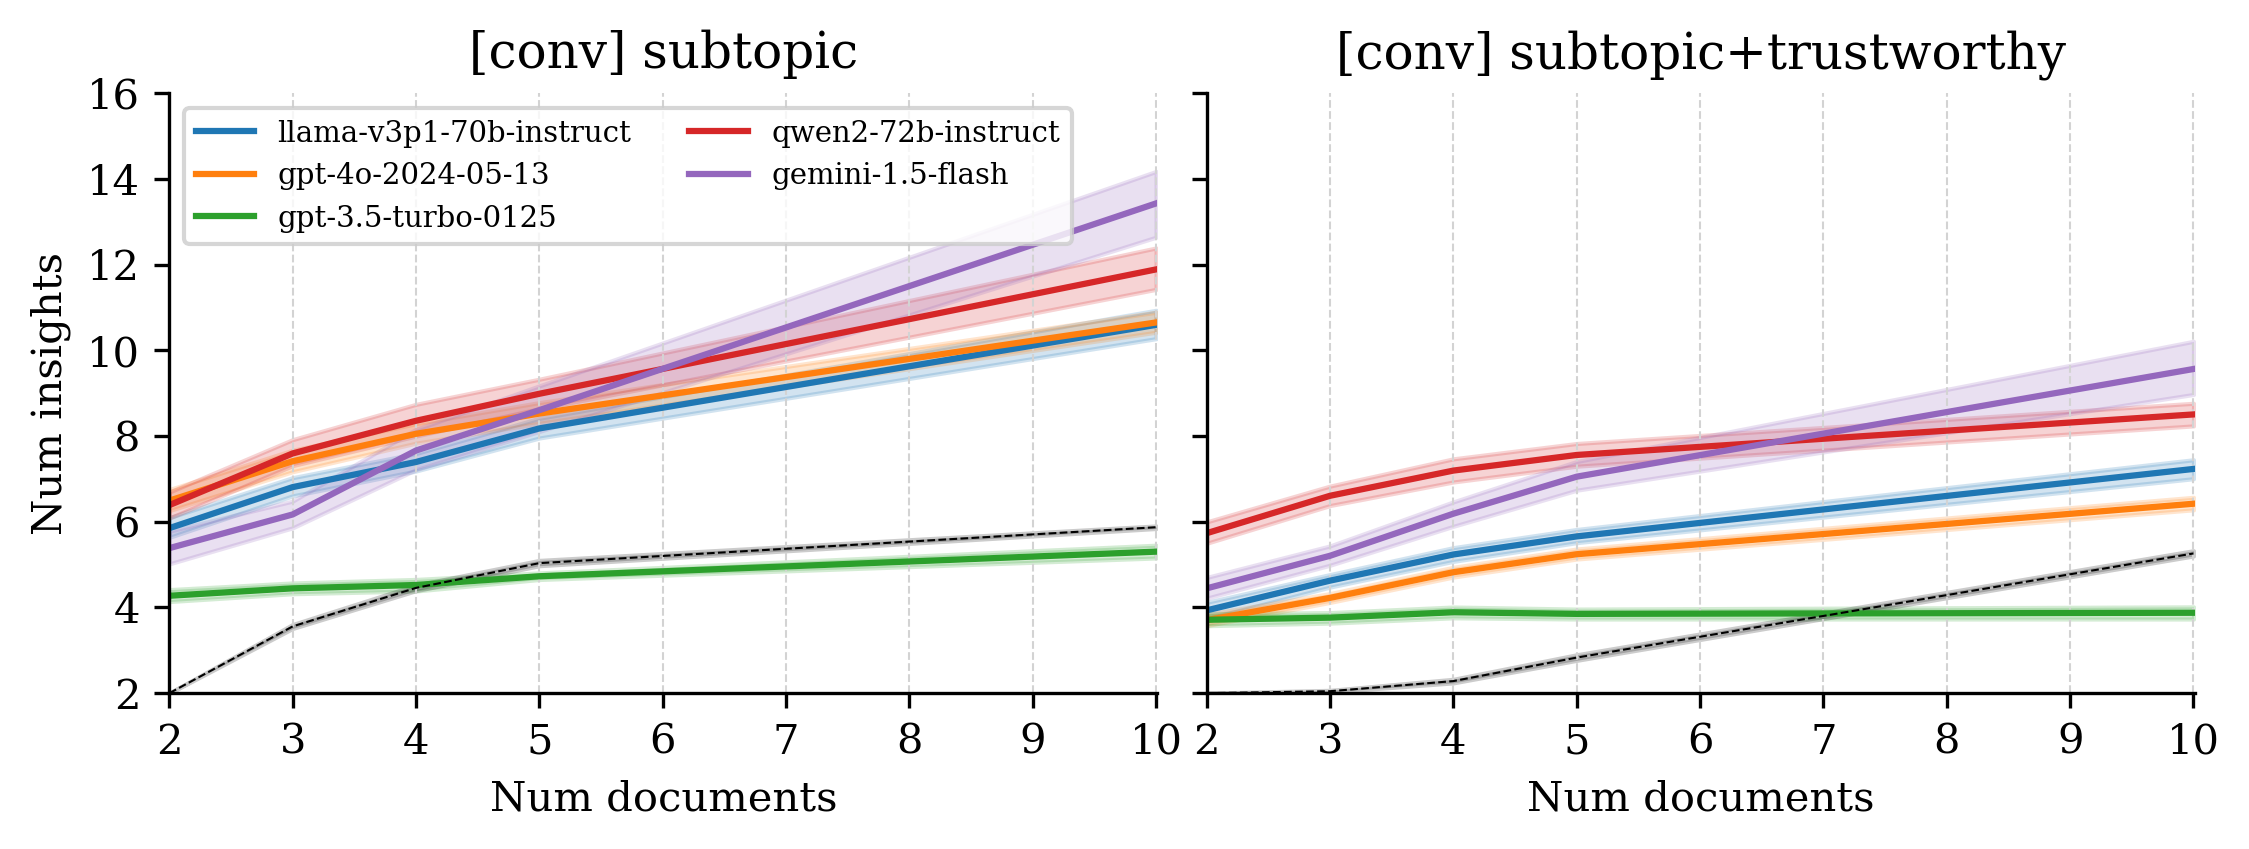

In [106]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)


ax = axes[0]
subset_err = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == "subtopic")
]
ax.set_title(f"[{domain}] subtopic")
sns.lineplot(subset_err, x="num_documents", y="n", hue="summarizer_model", ax=ax)
sns.lineplot(subset_recall, x="num_documents", y="n", ax=ax, color="black", linewidth=0.5, linestyle='--')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Num insights")

ax.set_xlim((2, 10.01))
ax.legend(loc="upper left", ncols=2, bbox_to_anchor=(0.0, 1), fontsize=7)

remove_axes(ax)

ax = axes[1]

subset_shared_recall = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc") 
    & (all_recall_results["summarizer_model"] == "llama-v3p1-70b-instruct")
    & (all_recall_results["prompt"] == "subtopic_trustworthy")
]
ax.set_title(f"[{domain}] subtopic+trustworthy")
sns.lineplot(subset_shared_err, x="num_documents", y="n", hue="summarizer_model", ax=ax)
sns.lineplot(subset_shared_recall, x="num_documents", y="n", ax=ax, color="black", linewidth=0.5, linestyle='--')
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Num Insights")

ax.set_xlim((2, 10.01))
ax.set_ylim(2, 16)
remove_axes(ax)
ax.get_legend().remove()

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}__{metric}__num_insights__both_prompts__{max_rank}.pdf", dpi=300)

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/num_preds_and_refs/both_prompts_n_ref_only__None.png


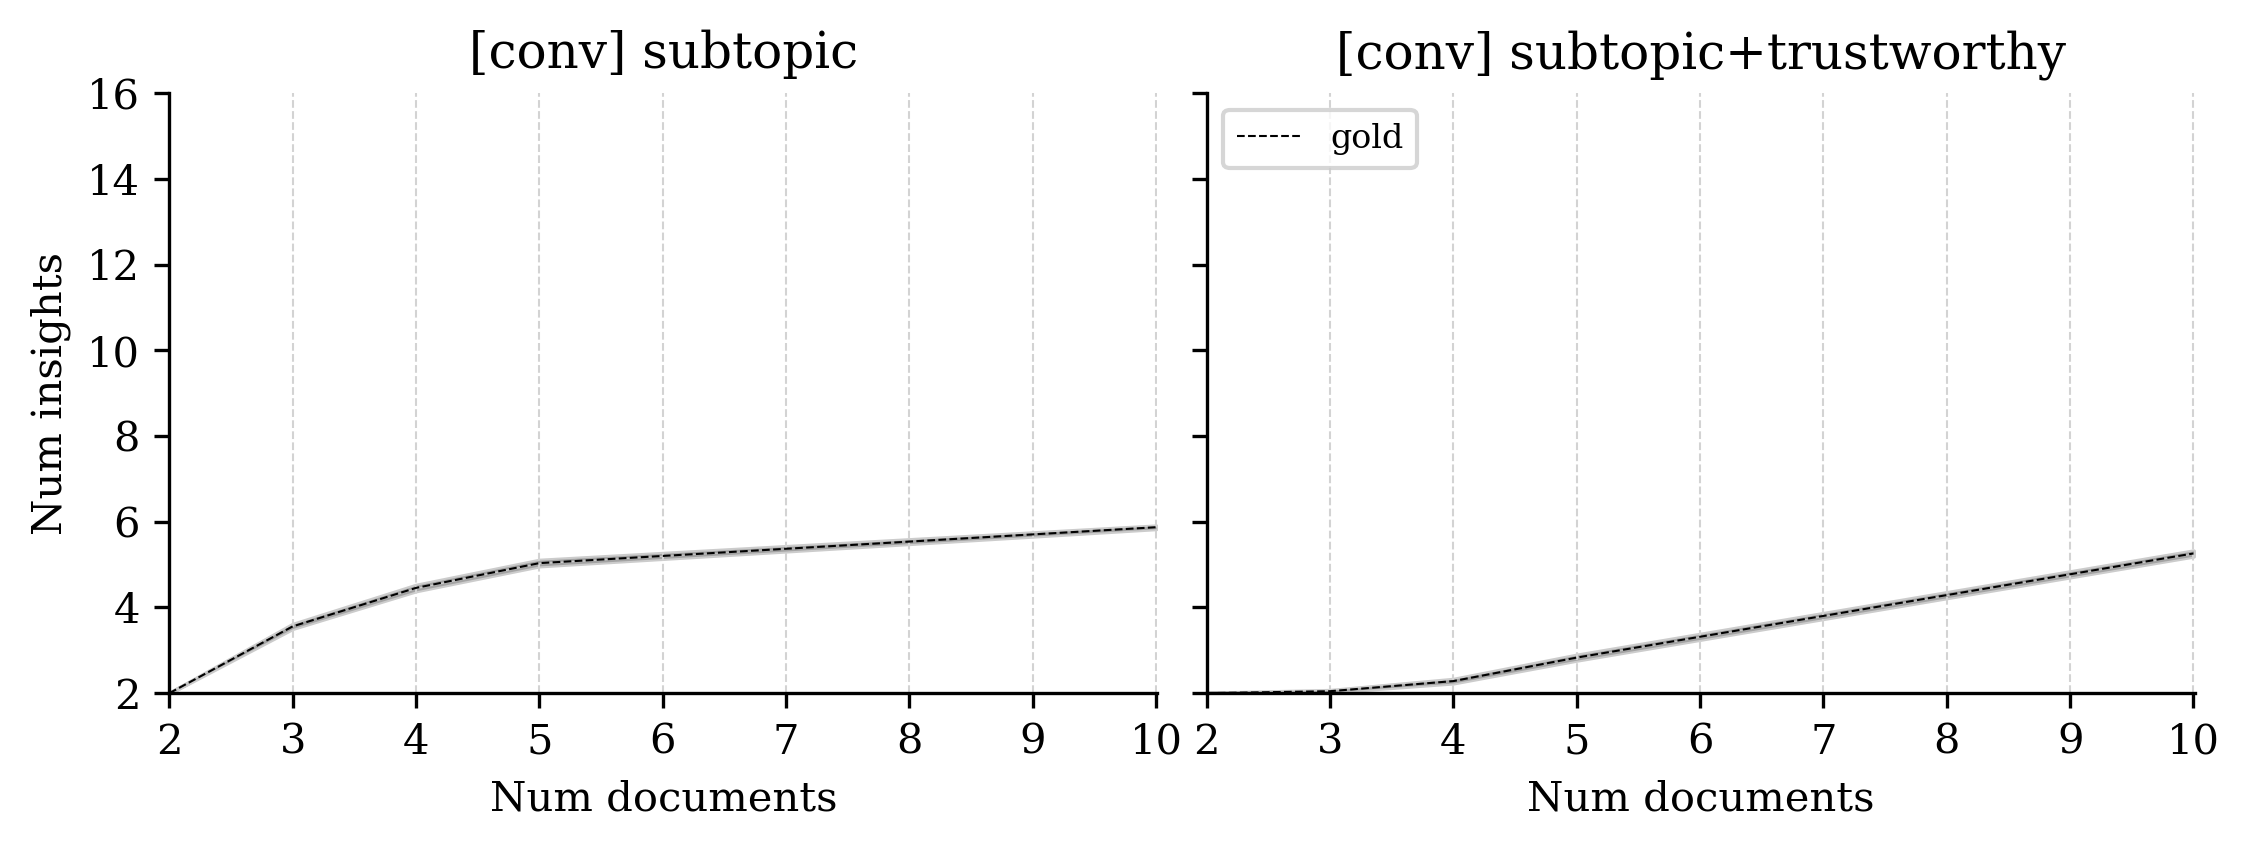

In [107]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)

subset_recall = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc") 
    & (all_recall_results["summarizer_model"] == "llama-v3p1-70b-instruct")
    & (all_recall_results["prompt"] == "subtopic")
]

ax = axes[0]
subset_err = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == "subtopic")
]
ax.set_title(f"[{domain}] subtopic")
# sns.lineplot(subset_err, x="num_documents", y="n", hue="summarizer_model", ax=ax)
sns.lineplot(subset_recall, x="num_documents", y="n", ax=ax, color="black", linewidth=0.5, linestyle='--')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray", label="gold")

ax.set_xlabel("Num documents")
ax.set_ylabel("Num insights")

ax.set_xlim((2, 10.01))

remove_axes(ax)

ax = axes[1]
subset_shared_err = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == "subtopic_trustworthy")
]

subset_shared_recall = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc") 
    & (all_recall_results["summarizer_model"] == "llama-v3p1-70b-instruct")
    & (all_recall_results["prompt"] == "subtopic_trustworthy")
]
ax.set_title(f"[{domain}] subtopic+trustworthy")
# sns.lineplot(subset_shared_err, x="num_documents", y="n", hue="summarizer_model", ax=ax)
sns.lineplot(subset_shared_recall, x="num_documents", y="n", ax=ax, color="black", linewidth=0.5, linestyle='--', label="gold")
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Num Insights")

ax.set_xlim((2, 10.01))
ax.set_ylim(2, 16)
remove_axes(ax)
ax.legend(loc="upper left", ncols=1, bbox_to_anchor=(0.0, 1), fontsize=8)

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}/{metric}/lineplot/num_preds_and_refs/both_prompts_n_ref_only__{max_rank}.png", dpi=300)

In [108]:
subset_recall[["n", "num_documents"]].groupby(["num_documents"]).describe()

n                                          
               count   mean       std  min  25%  50%  75%  max
num_documents                                                 
2              341.0  2.000  0.000000  2.0  2.0  2.0  2.0  2.0
3              500.0  3.558  0.539647  2.0  3.0  4.0  4.0  5.0
4              500.0  4.456  0.759749  2.0  4.0  4.0  5.0  6.0
5              500.0  5.034  0.708412  3.0  5.0  5.0  5.0  8.0
10             500.0  5.872  0.351943  5.0  6.0  6.0  6.0  8.0

In [109]:
subset_shared_recall[["n", "num_documents"]].groupby(["num_documents"]).describe()

n                                          
               count   mean       std  min  25%  50%  75%  max
num_documents                                                 
2              341.0  2.000  0.000000  2.0  2.0  2.0  2.0  2.0
3              500.0  2.046  0.209695  2.0  2.0  2.0  2.0  3.0
4              500.0  2.282  0.488829  2.0  2.0  2.0  3.0  4.0
5              500.0  2.830  0.708593  2.0  2.0  3.0  3.0  5.0
10             500.0  5.260  0.702415  3.0  5.0  5.0  6.0  6.0

## Compute the ratio


In [110]:
all_f1_results["preds_ratio"] = all_f1_results["n_err_rate"] / all_f1_results["n_recall"]

Image saved in ../paper-oct/images/conv__bidirectional__num_preds_and_refs__both_prompts__ratio__None.pdf


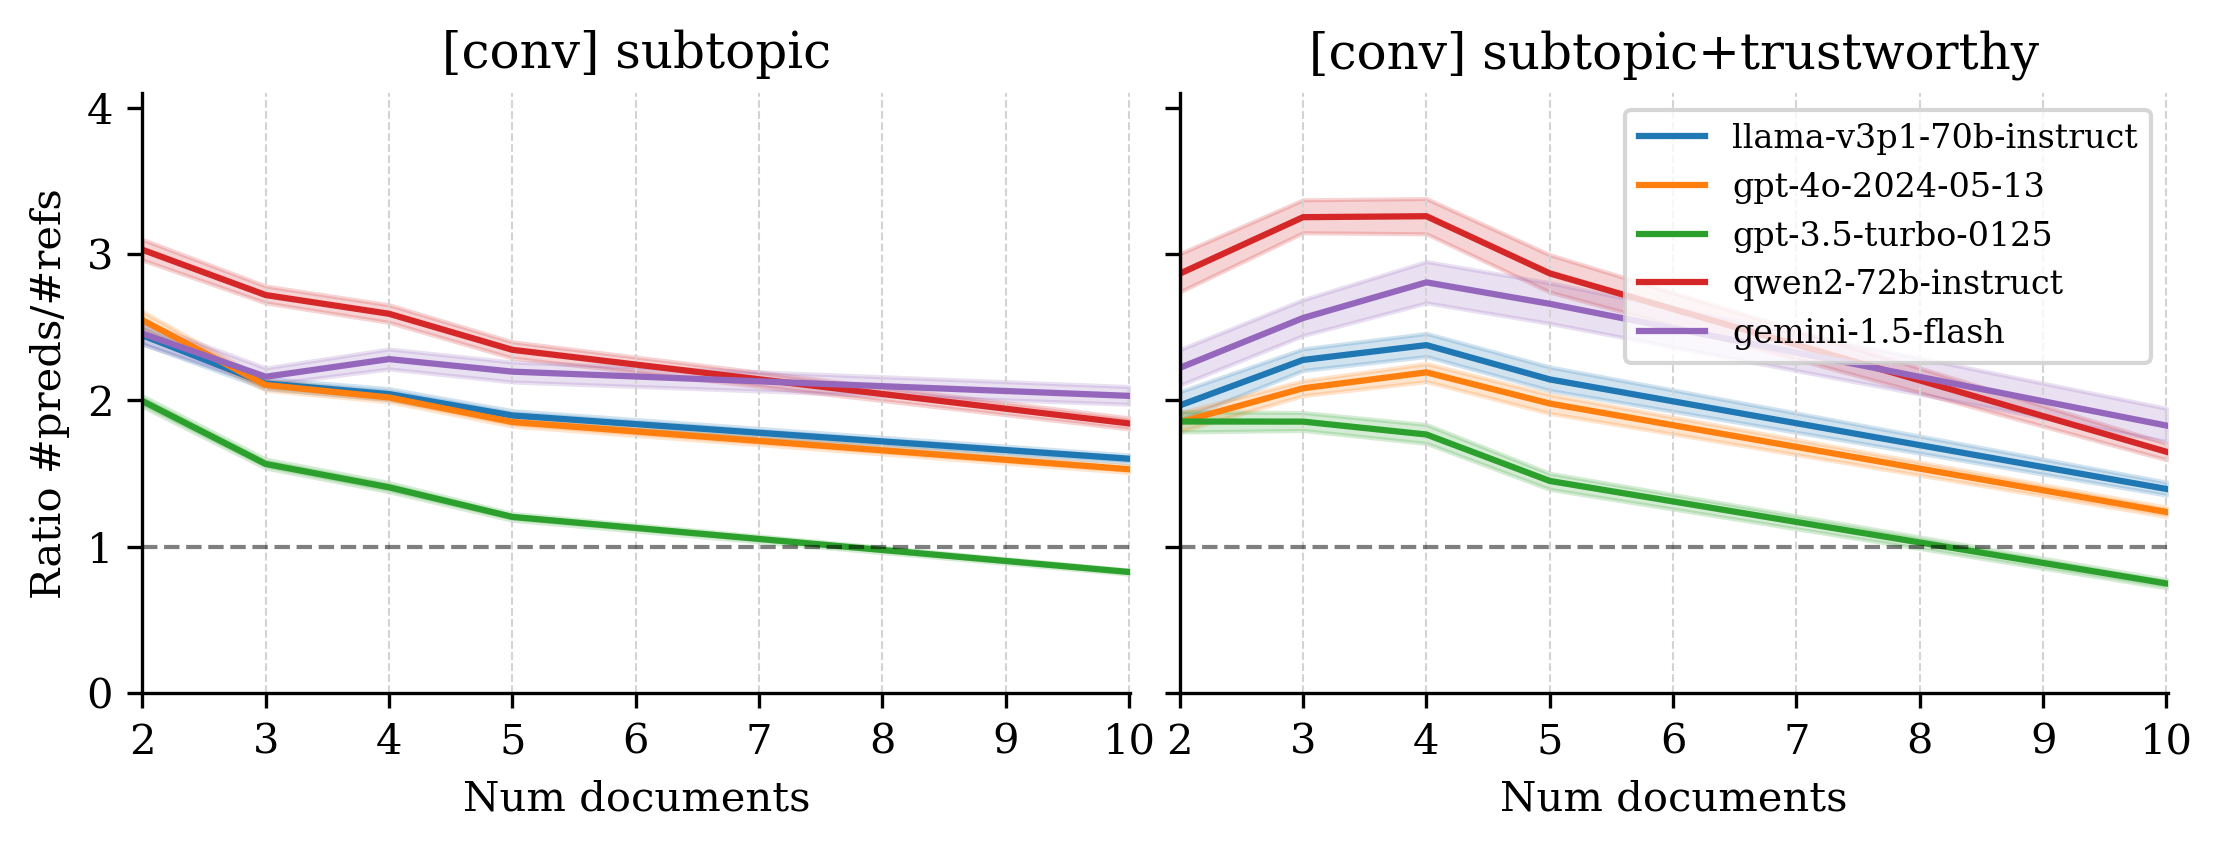

In [111]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)

ax = axes[0]
subset = all_f1_results[
    (all_f1_results["label_type"] == "fc+pc")
    & (all_f1_results["prompt"] == "subtopic")
]
ax.set_title(f"[{domain}] subtopic")
sns.lineplot(all_f1_results, x="num_documents", y="preds_ratio", hue="summarizer_model", ax=ax)
ax.axhline(1, color="black", ls="--", alpha=0.5, lw=1)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Ratio #preds/#refs")

ax.set_xlim((2, 10.01))
ax.get_legend().remove()

remove_axes(ax)

ax = axes[1]
subset_shared = all_f1_results[
    (all_f1_results["label_type"] == "fc+pc")
    & (all_f1_results["prompt"] == "subtopic_trustworthy")
]

ax.set_title(f"[{domain}] subtopic+trustworthy")
sns.lineplot(subset_shared, x="num_documents", y="preds_ratio", hue="summarizer_model", ax=ax)
ax.axhline(1, color="black", ls="--", alpha=0.5, lw=1)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.set_xlabel("Num documents")
ax.set_ylabel("Ratio")

ax.set_xlim((2, 10.01))
ax.set_ylim(0, 4.1)
remove_axes(ax)
ax.legend(loc="upper right", ncols=1, bbox_to_anchor=(1.0, 1), fontsize=8)

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}__{metric}__num_preds_and_refs__both_prompts__ratio__{max_rank}.pdf", dpi=400)

In [112]:
# one potential explanation for the decrease of the avg error
# rate when limiting the predictions to a fixed number of
# bullet points is that the likelihood of producing a correct
# insight increases as we increase the number of documents.
# ----------------------------------------------------------
# to validate the hypothesis above, we will plot the 
# number ref insights / number in context insights as a function
# of the number of documents
all_in_context_results = []
for model in MODELS:
    for prompt in PROMPT_SETTING:
        for combination in COMBINATIONS:
            filepaths = sorted(glob.glob(f"{base_dir}/{prompt}/SummHay__combinations-{combination}/{model}/{metric}__*.json"))            
            for filepath in filepaths: 
                data = read_json(filepath)
                recall_in_cont = compute_recall(data["labels"],
                                        ref_is_queried_subtopic=False,
                                        ref_is_shared=False,
                                        max_rank=max_rank)

                for df in (recall_in_cont,):
                    df["summarizer_model"] = model.rpartition("/")[-1]
                    df["prompt"] = prompt
                    df["num_documents"] = combination
                    df["metric"] = metric
                    df["filepath"] = filepath.rpartition(metric + "__")[-1]

                all_in_context_results.append(recall_in_cont)

all_in_context_results = pd.concat(all_in_context_results)

# Join the two recall results
# `all_recall_results` consider the different correctness criteria
a1 = all_recall_results.set_index(["summarizer_model", "prompt", "filepath", "response_id", "num_documents", "label_type"])
a1 = a1.drop(["compute_recall_kwargs", "metric"], axis=1)

# `all_in_context_results` considers whether the reference insight is in context
# (regardless of subtopic and whether it's shared)
a2 = all_in_context_results.set_index(["summarizer_model", "prompt", "filepath", "response_id", "num_documents", "label_type"])
a2 = a2.drop(["compute_recall_kwargs", "metric"], axis=1)

prev_correct_res = a1.join(a2, how="inner", lsuffix="__a1", rsuffix="__a2").reset_index()
prev_correct_res["ratio"] = prev_correct_res["n__a1"] / prev_correct_res["n__a2"]

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/base_rate/both_prompts__fc+pc.png


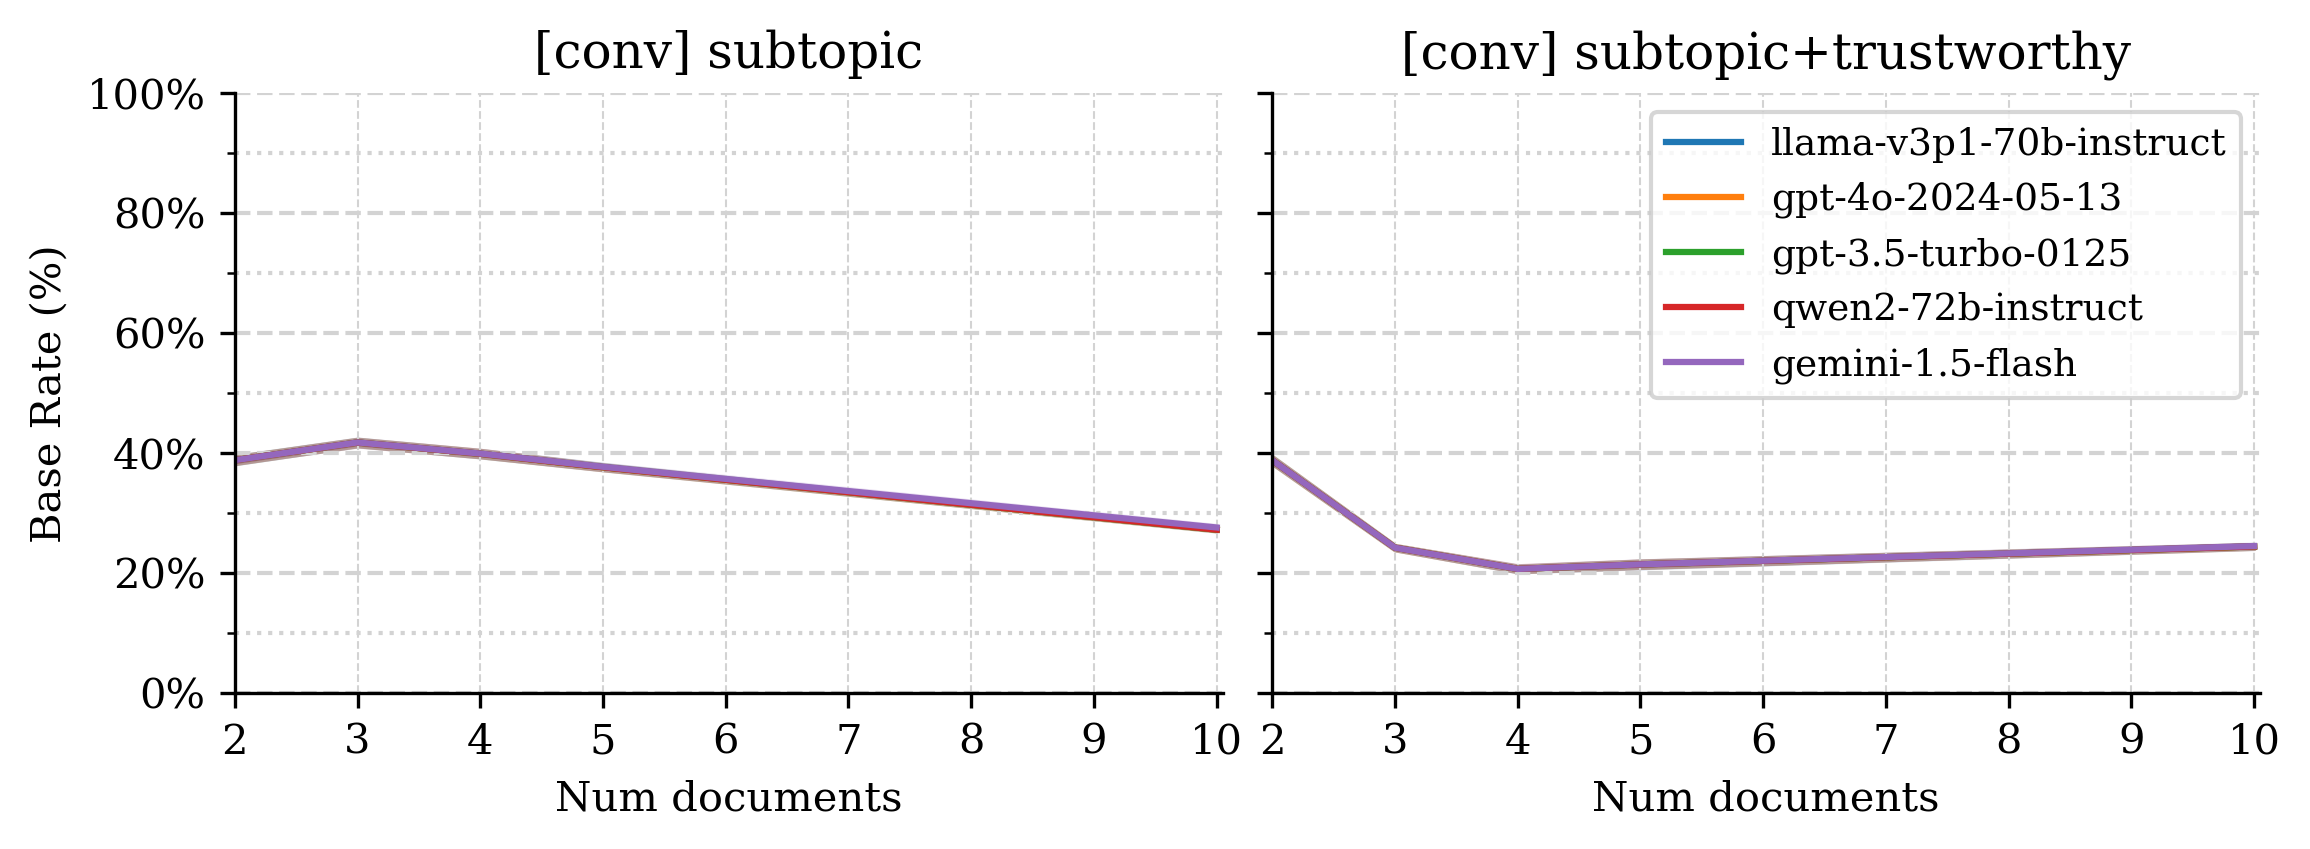

In [113]:
# -----
# plot
# -----
subset = prev_correct_res[(prev_correct_res["label_type"] == "fc+pc")]

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)
ax = axes[0]

ax.set_title(f"[{domain}] subtopic")
subset_subtopic = subset[(subset["prompt"] == "subtopic")]
sns.lineplot(subset_subtopic, x="num_documents", y="ratio", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Base Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.05))
ax.get_legend().remove()
remove_axes(ax)

ax = axes[1]
subset_subtopic_shared = subset[(subset["prompt"] == "subtopic_trustworthy")]
ax.set_title(f"[{domain}] subtopic+trustworthy")
sns.lineplot(subset_subtopic_shared, x="num_documents", y="ratio", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Base Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.05))
remove_axes(ax)
ax.legend(loc="upper right", ncols=1, bbox_to_anchor=(1.0, 1.0), fontsize=9)

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}/{metric}/lineplot/base_rate/both_prompts__fc+pc.png", dpi=300)

In [114]:
# given that models tend to produce less hallucinations in the 
# ref insihgt, it may be because the ratio shared_insight_subtopic / subtopic_insight is larger as we increase num of docs

In [115]:
def breakdown_labels_annotations(labels):
    counter = defaultdict(list)
    pred_labels = [l for l in labels if l["pred_uuid"] is not None]
    for pred in pred_labels:
        for label_type, cov_labels in {"fc": ("FULL_COVERAGE",), "fc+pc": ("FULL_COVERAGE", "PARTIAL_COVERAGE")}.items():
            counter["response_id"].append(pred["response_idx"])
            counter["label_type"].append(label_type)
            
            counter["is_shared"].append(pred["ref_is_shared"] is not None and pred["ref_is_shared"] and (pred["coverage"] in cov_labels))
            counter["is_queried_subtopic"].append(pred["ref_is_queried_subtopic"] is not None and pred["ref_is_queried_subtopic"] and (pred["coverage"] in cov_labels))
            counter["is_shared_and_queried_subtopic"].append(counter["is_queried_subtopic"][-1] and counter["is_shared"][-1])
    
            counter["in_context"].append(pred["ref_uuid"] is not None or pred["coverage"] in cov_labels)
            counter["not_in_context"].append(pred["ref_uuid"] == None or pred["coverage"] not in cov_labels)
            counter["pred_count"].append(1)
    
    counter = pd.DataFrame(counter)
    counter = counter.groupby(["label_type", "response_id"]).sum()
    
    for col in counter.columns[:-1]:
        counter[col] = np.round((counter[col] / counter["pred_count"]) * 100, 2)
    return counter.reset_index()

label_breakdown_results = []
for model in MODELS:
    for prompt in PROMPT_SETTING:
        for combination in COMBINATIONS:
            filepaths = sorted(glob.glob(f"{base_dir}/{prompt}/SummHay__combinations-{combination}/{model}/{metric}__*.json"))            
            for filepath in filepaths: 
                data = read_json(filepath)
                breakdown_res = breakdown_labels_annotations(data["labels"])
                                        #ref_is_queried_subtopic=True,
                                        #ref_is_shared=(prompt == "subtopic_trustworthy"),
                                        #max_rank=max_rank)

                for df in (breakdown_res,):
                    df["summarizer_model"] = model.rpartition("/")[-1]
                    df["prompt"] = prompt
                    df["num_documents"] = combination
                    df["metric"] = metric
                    df["filepath"] = filepath.rpartition(metric + "__")[-1]

                label_breakdown_results.append(breakdown_res)

label_breakdown_results = pd.concat(label_breakdown_results)


# Create a table w/ average and std
subset = label_breakdown_results[label_breakdown_results["label_type"] == "fc+pc"].drop(["metric", "filepath", "label_type", "response_id"], axis=1)

In [116]:
subset_subtopic = subset[subset["prompt"] == "subtopic"].drop(["prompt", "pred_count"], axis=1)
subset_subtopic_trust = subset[subset["prompt"] == "subtopic_trustworthy"].drop(["prompt", "pred_count"], axis=1)

def format_subset_mean_std(subset):
    subset_mean = subset.groupby(["num_documents", "summarizer_model"]).mean().round(2)
    subset_std = subset.groupby(["num_documents", "summarizer_model"]).std().round(2)
    
    assert all(subset_mean.index == subset_std.index)
    subset_mean = subset_mean.reset_index()
    subset_std = subset_std.reset_index()
    
    subset_formatted = subset_mean.copy() 
    for col in subset_formatted.columns[2:]:
        subset_formatted[col] = "$" + subset_mean[col].astype(str) + "_{\pm " + subset_std[col].astype(str) + "}$"
    return subset_formatted


# subset_subtopic_formatted.to_latex(escape=False)

# TODO: Add color
print(format_subset_mean_std(subset_subtopic).to_latex(escape=False, caption=f"Analysis of summarizer predictions in the {domain} domain, when using the subtopic prompt.", label=f"tab:metric-{metric}:pred-breakdown-subtopic-{domain}", index=False, sparsify=True, multirow=True))
print("\n\n\n")
print(format_subset_mean_std(subset_subtopic_trust).to_latex(escape=False, caption=f"Analysis of summarizer predictions in the {domain} domain, when using the subtopic+trust prompt.", label=f"tab:metric-{metric}:pred-breakdown-subtopic-trust-{domain}", index=False, sparsify=True, multirow=True))

\begin{table}
\caption{Analysis of summarizer predictions in the conv domain, when using the subtopic prompt.}
\label{tab:metric-bidirectional:pred-breakdown-subtopic-conv}
\begin{tabular}{rllllll}
\toprule
num_documents & summarizer_model & is_shared & is_queried_subtopic & is_shared_and_queried_subtopic & in_context & not_in_context \\
\midrule
2 & gemini-1.5-flash & $35.59_{\pm 20.7}$ & $35.48_{\pm 20.62}$ & $35.48_{\pm 20.62}$ & $38.92_{\pm 22.39}$ & $61.08_{\pm 22.39}$ \\
2 & gpt-3.5-turbo-0125 & $37.85_{\pm 23.66}$ & $37.61_{\pm 23.56}$ & $37.61_{\pm 23.56}$ & $45.48_{\pm 23.91}$ & $54.52_{\pm 23.91}$ \\
2 & gpt-4o-2024-05-13 & $29.43_{\pm 14.37}$ & $29.34_{\pm 14.29}$ & $29.34_{\pm 14.29}$ & $35.9_{\pm 17.18}$ & $64.1_{\pm 17.18}$ \\
2 & llama-v3p1-70b-instruct & $32.01_{\pm 17.17}$ & $31.93_{\pm 17.13}$ & $31.93_{\pm 17.13}$ & $38.03_{\pm 18.53}$ & $61.97_{\pm 18.53}$ \\
2 & qwen2-72b-instruct & $31.58_{\pm 15.44}$ & $31.53_{\pm 15.41}$ & $31.53_{\pm 15.41}$ & $38.98_{\pm 18.62

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_697179/1400030325.py:14: SyntaxWarning: invalid escape sequence '\p'
  subset_formatted[col] = "$" + subset_mean[col].astype(str) + "_{\pm " + subset_std[col].astype(str) + "}$"


In [117]:
format_subset_mean_std(subset_subtopic)

,num_documents,summarizer_model,is_shared,is_queried_subtopic,is_shared_and_queried_subtopic,in_context,not_in_context
0,2,gemini-1.5-flash,$35.59_{\pm 20.7}$,$35.48_{\pm 20.62}$,$35.48_{\pm 20.62}$,$38.92_{\pm 22.39}$,$61.08_{\pm 22.39}$
1,2,gpt-3.5-turbo-0125,$37.85_{\pm 23.66}$,$37.61_{\pm 23.56}$,$37.61_{\pm 23.56}$,$45.48_{\pm 23.91}$,$54.52_{\pm 23.91}$
2,2,gpt-4o-2024-05-13,$29.43_{\pm 14.37}$,$29.34_{\pm 14.29}$,$29.34_{\pm 14.29}$,$35.9_{\pm 17.18}$,$64.1_{\pm 17.18}$
3,2,llama-v3p1-70b-instruct,$32.01_{\pm 17.17}$,$31.93_{\pm 17.13}$,$31.93_{\pm 17.13}$,$38.03_{\pm 18.53}$,$61.97_{\pm 18.53}$
4,2,qwen2-72b-instruct,$31.58_{\pm 15.44}$,$31.53_{\pm 15.41}$,$31.53_{\pm 15.41}$,$38.98_{\pm 18.62}$,$61.02_{\pm 18.62}$
5,3,gemini-1.5-flash,$27.55_{\pm 15.94}$,$44.18_{\pm 22.25}$,$27.35_{\pm 15.98}$,$48.59_{\pm 23.1}$,$51.41_{\pm 23.1}$
6,3,gpt-3.5-turbo-0125,$28.48_{\pm 18.87}$,$40.42_{\pm 25.18}$,$28.0_{\pm 18.75}$,$49.74_{\pm 26.02}$,$50.26_{\pm 26.02}$
7,3,gpt-4o-2024-05-13,$25.37_{\pm 12.84}$,$40.79_{\pm 17.86}$,$25.17_{\pm 12.86}$,$49.33_{\pm 20.53}$,$50.67_{\pm 20.53}$
8,3,llama-v3p1-70b-instruct,$25.24_{\pm 13.22}$,$39.18_{\pm 18.64}$,$24.92_{\pm 13.01}$,$46.43_{\pm 20.78}$,$53.57_{\pm 20.78}$
9,3,qwen2-72b-instruct,$26.47_{\pm 12.89}$,$41.48_{\pm 18.79}$,$26.06_{\pm 12.81}$,$50.89_{\pm 21.11}$,$49.11_{\pm 21.11}$


In [118]:
format_subset_mean_std(subset_subtopic_trust)

,num_documents,summarizer_model,is_shared,is_queried_subtopic,is_shared_and_queried_subtopic,in_context,not_in_context
0,2,gemini-1.5-flash,$39.07_{\pm 22.93}$,$39.0_{\pm 22.85}$,$39.0_{\pm 22.85}$,$41.87_{\pm 24.55}$,$58.13_{\pm 24.55}$
1,2,gpt-3.5-turbo-0125,$37.81_{\pm 24.78}$,$37.68_{\pm 24.75}$,$37.68_{\pm 24.75}$,$44.35_{\pm 26.12}$,$55.65_{\pm 26.12}$
2,2,gpt-4o-2024-05-13,$46.06_{\pm 23.59}$,$45.79_{\pm 23.59}$,$45.79_{\pm 23.59}$,$49.38_{\pm 23.77}$,$50.62_{\pm 23.77}$
3,2,llama-v3p1-70b-instruct,$40.95_{\pm 27.0}$,$40.89_{\pm 26.98}$,$40.89_{\pm 26.98}$,$45.47_{\pm 27.47}$,$54.53_{\pm 27.47}$
4,2,qwen2-72b-instruct,$35.5_{\pm 18.28}$,$35.39_{\pm 18.18}$,$35.39_{\pm 18.18}$,$43.46_{\pm 20.35}$,$56.54_{\pm 20.35}$
5,3,gemini-1.5-flash,$28.77_{\pm 20.21}$,$43.1_{\pm 26.56}$,$28.68_{\pm 20.18}$,$46.53_{\pm 27.67}$,$53.47_{\pm 27.67}$
6,3,gpt-3.5-turbo-0125,$31.37_{\pm 25.85}$,$42.43_{\pm 30.09}$,$30.78_{\pm 25.58}$,$50.09_{\pm 30.79}$,$49.91_{\pm 30.79}$
7,3,gpt-4o-2024-05-13,$39.23_{\pm 22.05}$,$53.83_{\pm 25.02}$,$38.87_{\pm 21.75}$,$59.5_{\pm 26.03}$,$40.5_{\pm 26.03}$
8,3,llama-v3p1-70b-instruct,$31.09_{\pm 22.19}$,$43.72_{\pm 27.29}$,$30.82_{\pm 22.24}$,$48.5_{\pm 27.85}$,$51.5_{\pm 27.85}$
9,3,qwen2-72b-instruct,$28.24_{\pm 13.88}$,$44.08_{\pm 20.01}$,$27.92_{\pm 13.83}$,$52.93_{\pm 21.66}$,$47.07_{\pm 21.66}$


## F1 Score

In [119]:
all_f1_results.groupby(["summarizer_model", "num_documents", "prompt", "label_type"]).count()

filepath  \
summarizer_model   num_documents prompt               label_type             
gemini-1.5-flash   2             subtopic             fc               341   
                                                      fc+pc            341   
                                 subtopic_trustworthy fc               341   
                                                      fc+pc            341   
                   3             subtopic             fc               500   
...                                                                    ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc            500   
                   10            subtopic             fc               500   
                                                      fc+pc            500   
                                 subtopic_trustworthy fc               500   
                                                      fc+pc            500   

                                                                  response_id  \
summarizer_model   num_documents prompt               label_type                
gemini-1.5-flash   2             subtopic             fc                  341   
                                                      fc+pc               341   
                                 subtopic_trustworthy fc                  341   
                                                      fc+pc               341   
                   3             subtopic             fc                  500   
...                                                                       ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc               500   
                   10            subtopic             fc                  500   
                                                      fc+pc               500   
                                 subtopic_trustworthy fc                  500   
                                                      fc+pc               500   

                                                                  n_recall  \
summarizer_model   num_documents prompt               label_type             
gemini-1.5-flash   2             subtopic             fc               341   
                                                      fc+pc            341   
                                 subtopic_trustworthy fc               341   
                                                      fc+pc            341   
                   3             subtopic             fc               500   
...                                                                    ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc            500   
                   10            subtopic             fc               500   
                                                      fc+pc            500   
                                 subtopic_trustworthy fc               500   
                                                      fc+pc            500   

                                                                  tp_recall  \
summarizer_model   num_documents prompt               label_type              
gemini-1.5-flash   2             subtopic             fc                341   
                                                      fc+pc             341   
                                 subtopic_trustworthy fc                341   
                                                      fc+pc             341   
                   3             subtopic             fc                500   
...                                                                     ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc             500   
                   10            subtopic             fc                500   
                                                      fc+pc             500   
                                 subtopic_trustworthy fc                500   
                                  

In [120]:
for model in MODELS:
    print()
    print(model, "\n", read_json(f"../outputs_news/generate_summaries/results_some_shared/subtopic/SummHay__combinations-5/{model}/topic_news4__300__examples0,100.json")["assignments"][45]["response"])


accounts/fireworks/models/llama-v3p1-70b-instruct 
 - Elon Musk's behavior has had a notable impact on consumer perceptions of Tesla, with incidents such as steering wheels falling off contributing to an eroding sense of trust in Tesla's safety standards.
- Musk's unpredictable behavior, often exhibited through his own use of Twitter, has not helped mitigate these concerns and has had a measurable effect on Tesla's stock prices and consumer sentiment.
- Musk's public statements and policy changes on Twitter have caused some consumers to reassess their political alignment and, subsequently, their decision to purchase a Tesla.
- The impact of Musk's personal brand on Tesla's branding and public relations is significant, with his behavior on Twitter continuing to influence consumer perceptions of the company.
- Musk's polarizing persona complicates Tesla's ability to manage its brand reputation effectively, adding another layer of complexity to an already precarious situation.

gpt-4o-20

Image saved in ../paper-oct/images/conv__bidirectional__lineplot__f1-score__both_prompts__fc+pc__None.png


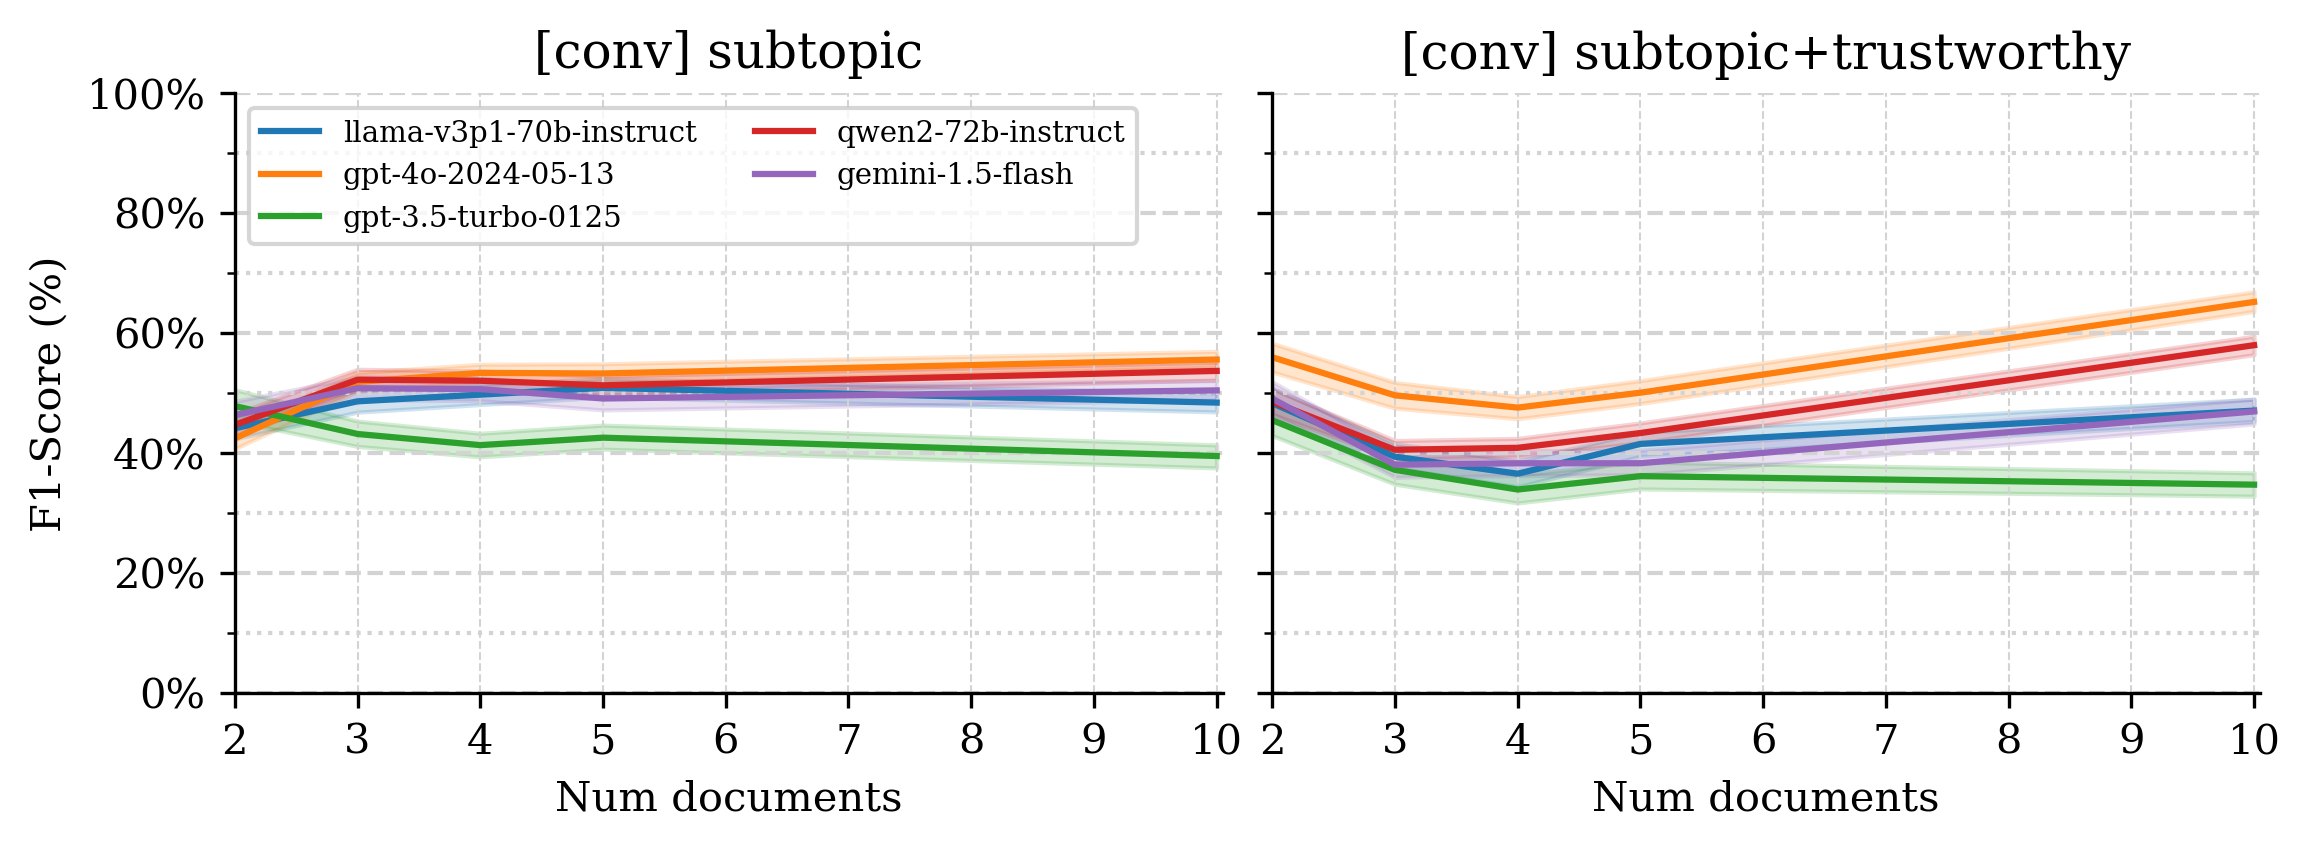

In [121]:
subset = all_f1_results[(all_f1_results["label_type"] == "fc+pc")]

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)

ax = axes[0]
ax.set_title(f"[{domain}] subtopic")
subset_subtopic = subset[(subset["prompt"] == "subtopic")]
sns.lineplot(subset_subtopic, x="num_documents", y="f1_score", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("F1-Score (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.05))
ax.legend(loc="upper left", ncols=2, bbox_to_anchor=(0, 1), fontsize=7)

remove_axes(ax)

ax = axes[1]
subset_subtopic_shared = subset[(subset["prompt"] == "subtopic_trustworthy")]
ax.set_title(f"[{domain}] subtopic+trustworthy")
sns.lineplot(subset_subtopic_shared, x="num_documents", y="f1_score", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("F1-score (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.05))
remove_axes(ax)
ax.get_legend().remove()

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}__{metric}__lineplot__f1-score__both_prompts__fc+pc__{max_rank}.png", dpi=300)

In [122]:
subset_subtopic[["num_documents", "summarizer_model", "f1_score"]].groupby(["num_documents", "summarizer_model",]).mean()

f1_score
num_documents summarizer_model                 
2             gemini-1.5-flash         0.463432
              gpt-3.5-turbo-0125       0.478498
              gpt-4o-2024-05-13        0.424660
              llama-v3p1-70b-instruct  0.441526
              qwen2-72b-instruct       0.447105
3             gemini-1.5-flash         0.508280
              gpt-3.5-turbo-0125       0.431945
              gpt-4o-2024-05-13        0.518680
              llama-v3p1-70b-instruct  0.486399
              qwen2-72b-instruct       0.522543
4             gemini-1.5-flash         0.506722
              gpt-3.5-turbo-0125       0.413413
              gpt-4o-2024-05-13        0.533835
              llama-v3p1-70b-instruct  0.497535
              qwen2-72b-instruct       0.520699
5             gemini-1.5-flash         0.491099
              gpt-3.5-turbo-0125       0.425834
              gpt-4o-2024-05-13        0.532851
              llama-v3p1-70b-instruct  0.508835
              qwen2-72b-instruct       0.513082
10            gemini-1.5-flash         0.504646
              gpt-3.5-turbo-0125       0.395250
              gpt-4o-2024-05-13        0.556060
              llama-v3p1-70b-instruct  0.484274
              qwen2-72b-instruct       0.537094

## Recall

In [123]:
all_recall_results.groupby(["summarizer_model", "num_documents", "prompt", "label_type"]).count()

response_id  \
summarizer_model   num_documents prompt               label_type                
gemini-1.5-flash   2             subtopic             fc                  341   
                                                      fc+pc               341   
                                 subtopic_trustworthy fc                  341   
                                                      fc+pc               341   
                   3             subtopic             fc                  500   
...                                                                       ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc               500   
                   10            subtopic             fc                  500   
                                                      fc+pc               500   
                                 subtopic_trustworthy fc                  500   
                                                      fc+pc               500   

                                                                    n   tp  \
summarizer_model   num_documents prompt               label_type             
gemini-1.5-flash   2             subtopic             fc          341  341   
                                                      fc+pc       341  341   
                                 subtopic_trustworthy fc          341  341   
                                                      fc+pc       341  341   
                   3             subtopic             fc          500  500   
...                                                               ...  ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc       500  500   
                   10            subtopic             fc          500  500   
                                                      fc+pc       500  500   
                                 subtopic_trustworthy fc          500  500   
                                                      fc+pc       500  500   

                                                                  fraction  \
summarizer_model   num_documents prompt               label_type             
gemini-1.5-flash   2             subtopic             fc               341   
                                                      fc+pc            341   
                                 subtopic_trustworthy fc               341   
                                                      fc+pc            341   
                   3             subtopic             fc               500   
...                                                                    ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc            500   
                   10            subtopic             fc               500   
                                                      fc+pc            500   
                                 subtopic_trustworthy fc               500   
                                                      fc+pc            500   

                                                                  compute_recall_kwargs  \
summarizer_model   num_documents prompt               label_type                          
gemini-1.5-flash   2             subtopic             fc                            341   
                                                      fc+pc                         341   
                                 subtopic_trustworthy fc                            341   
                                                      fc+pc                         341   
                   3             subtopic             fc                            500   
...                                                                                 ...   
qwen2-72b-instruct 5             subtopic_trustworthy fc+pc                         500   
                   10            subtopic             fc                            500   
                                                      fc+pc             

#### Subtopic Recall Plots

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/recall/subtopic__fc+pc__empty_frame.png


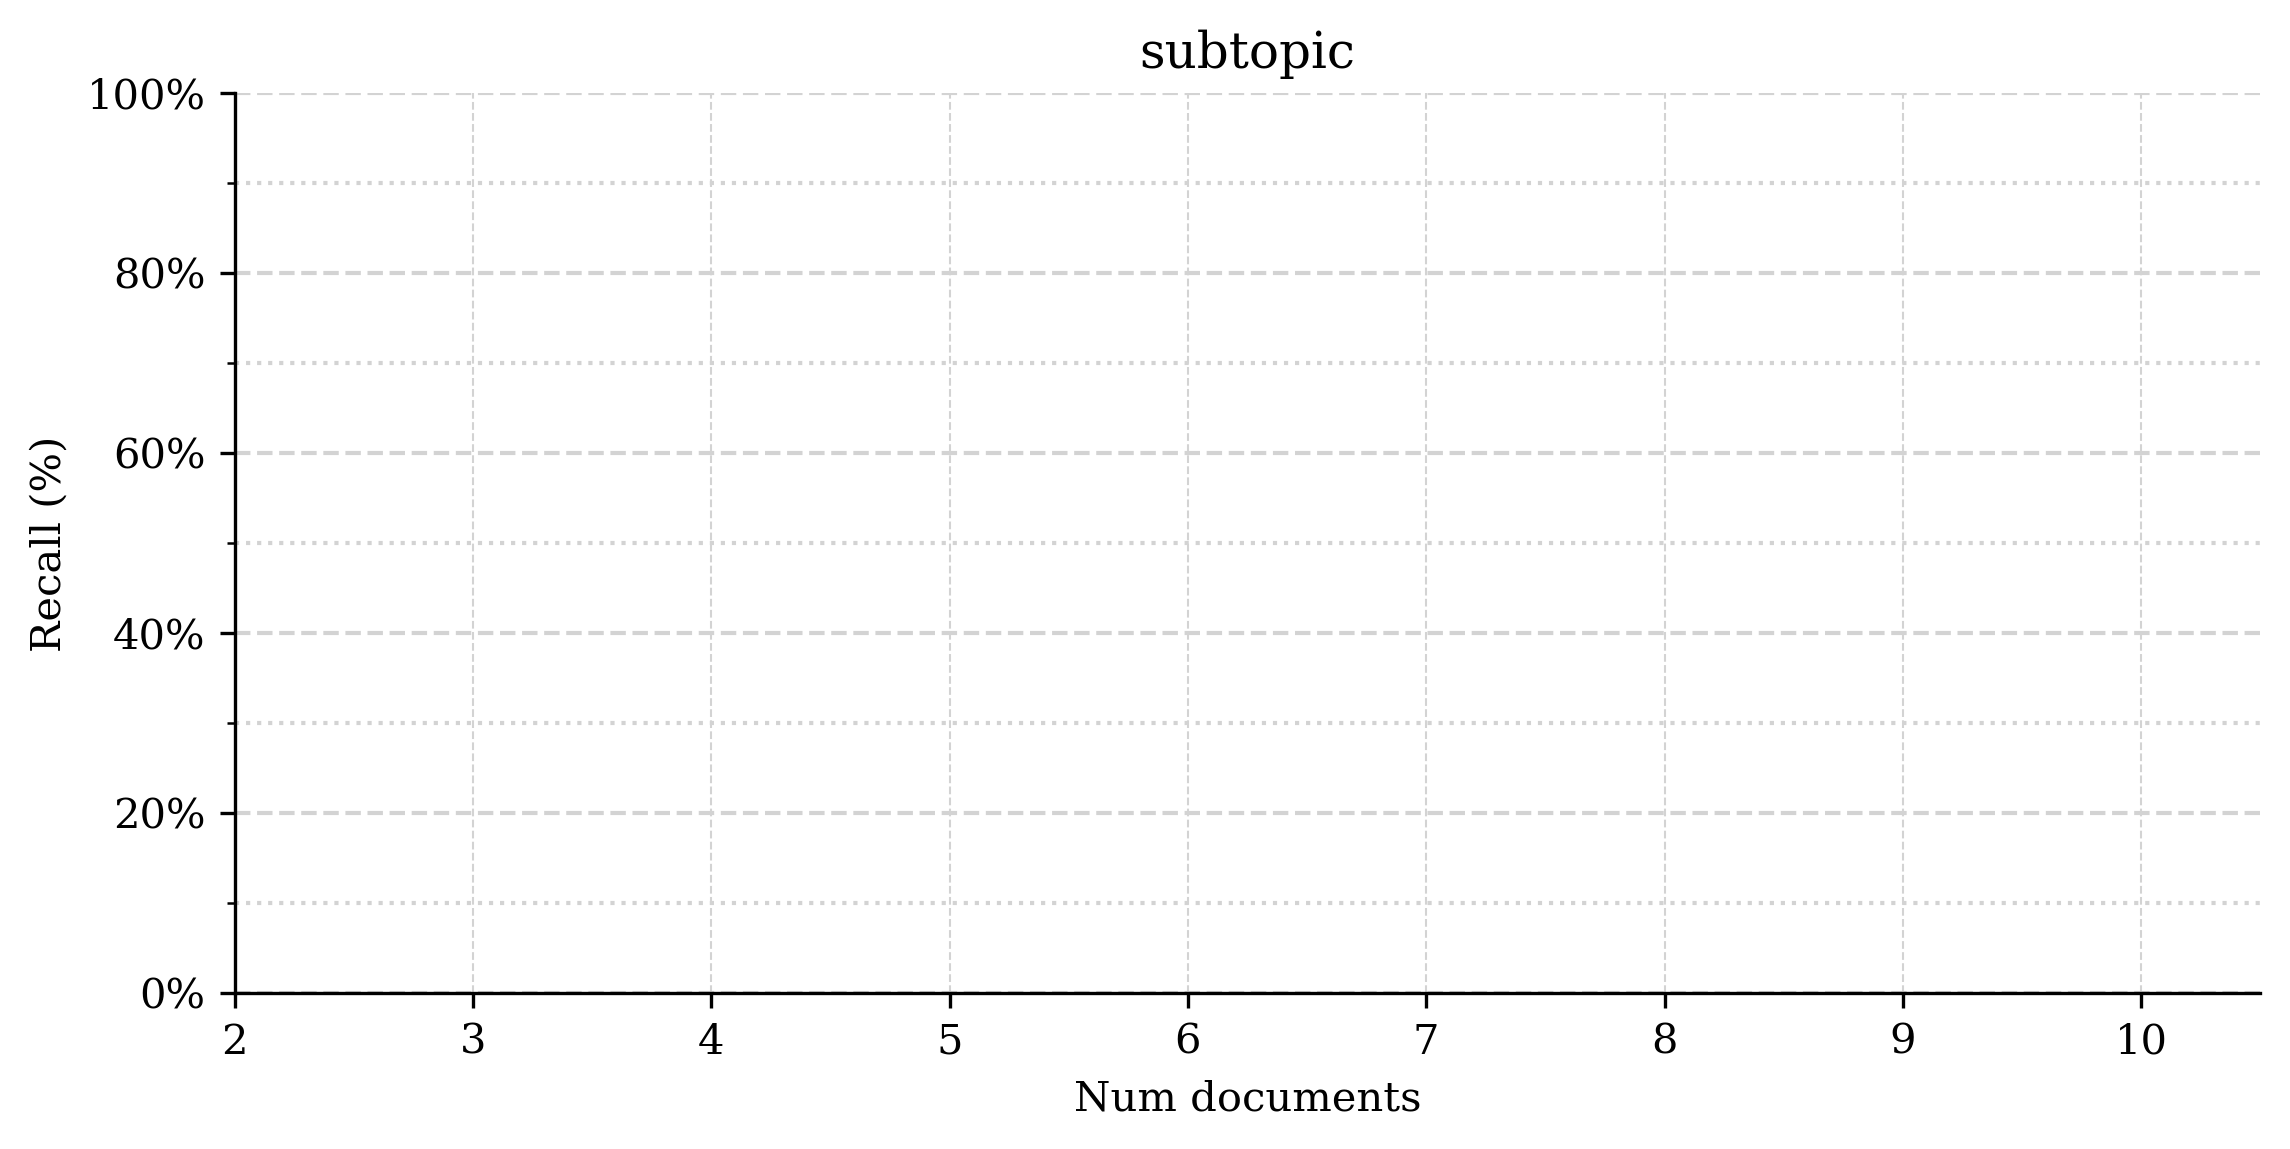

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(FULL_WIDTH, 3), dpi=300)
subset = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc")
    & (all_recall_results["summarizer_model"] == "llamaa-v3p1-70b-instruct")
    & (all_recall_results["prompt"] == "subtopic")
]
ax.set_title(f"subtopic")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model")

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Recall (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.5))

remove_axes(ax)
adjust(fig)
save_fig(fig, f"{domain}/{metric}/lineplot/recall/subtopic__fc+pc__empty_frame.png", dpi=300)

Image saved in ../paper-oct/images/conv/bidirectional/lineplot/recall/subtopic__fc+pc__llama3.1__None.png


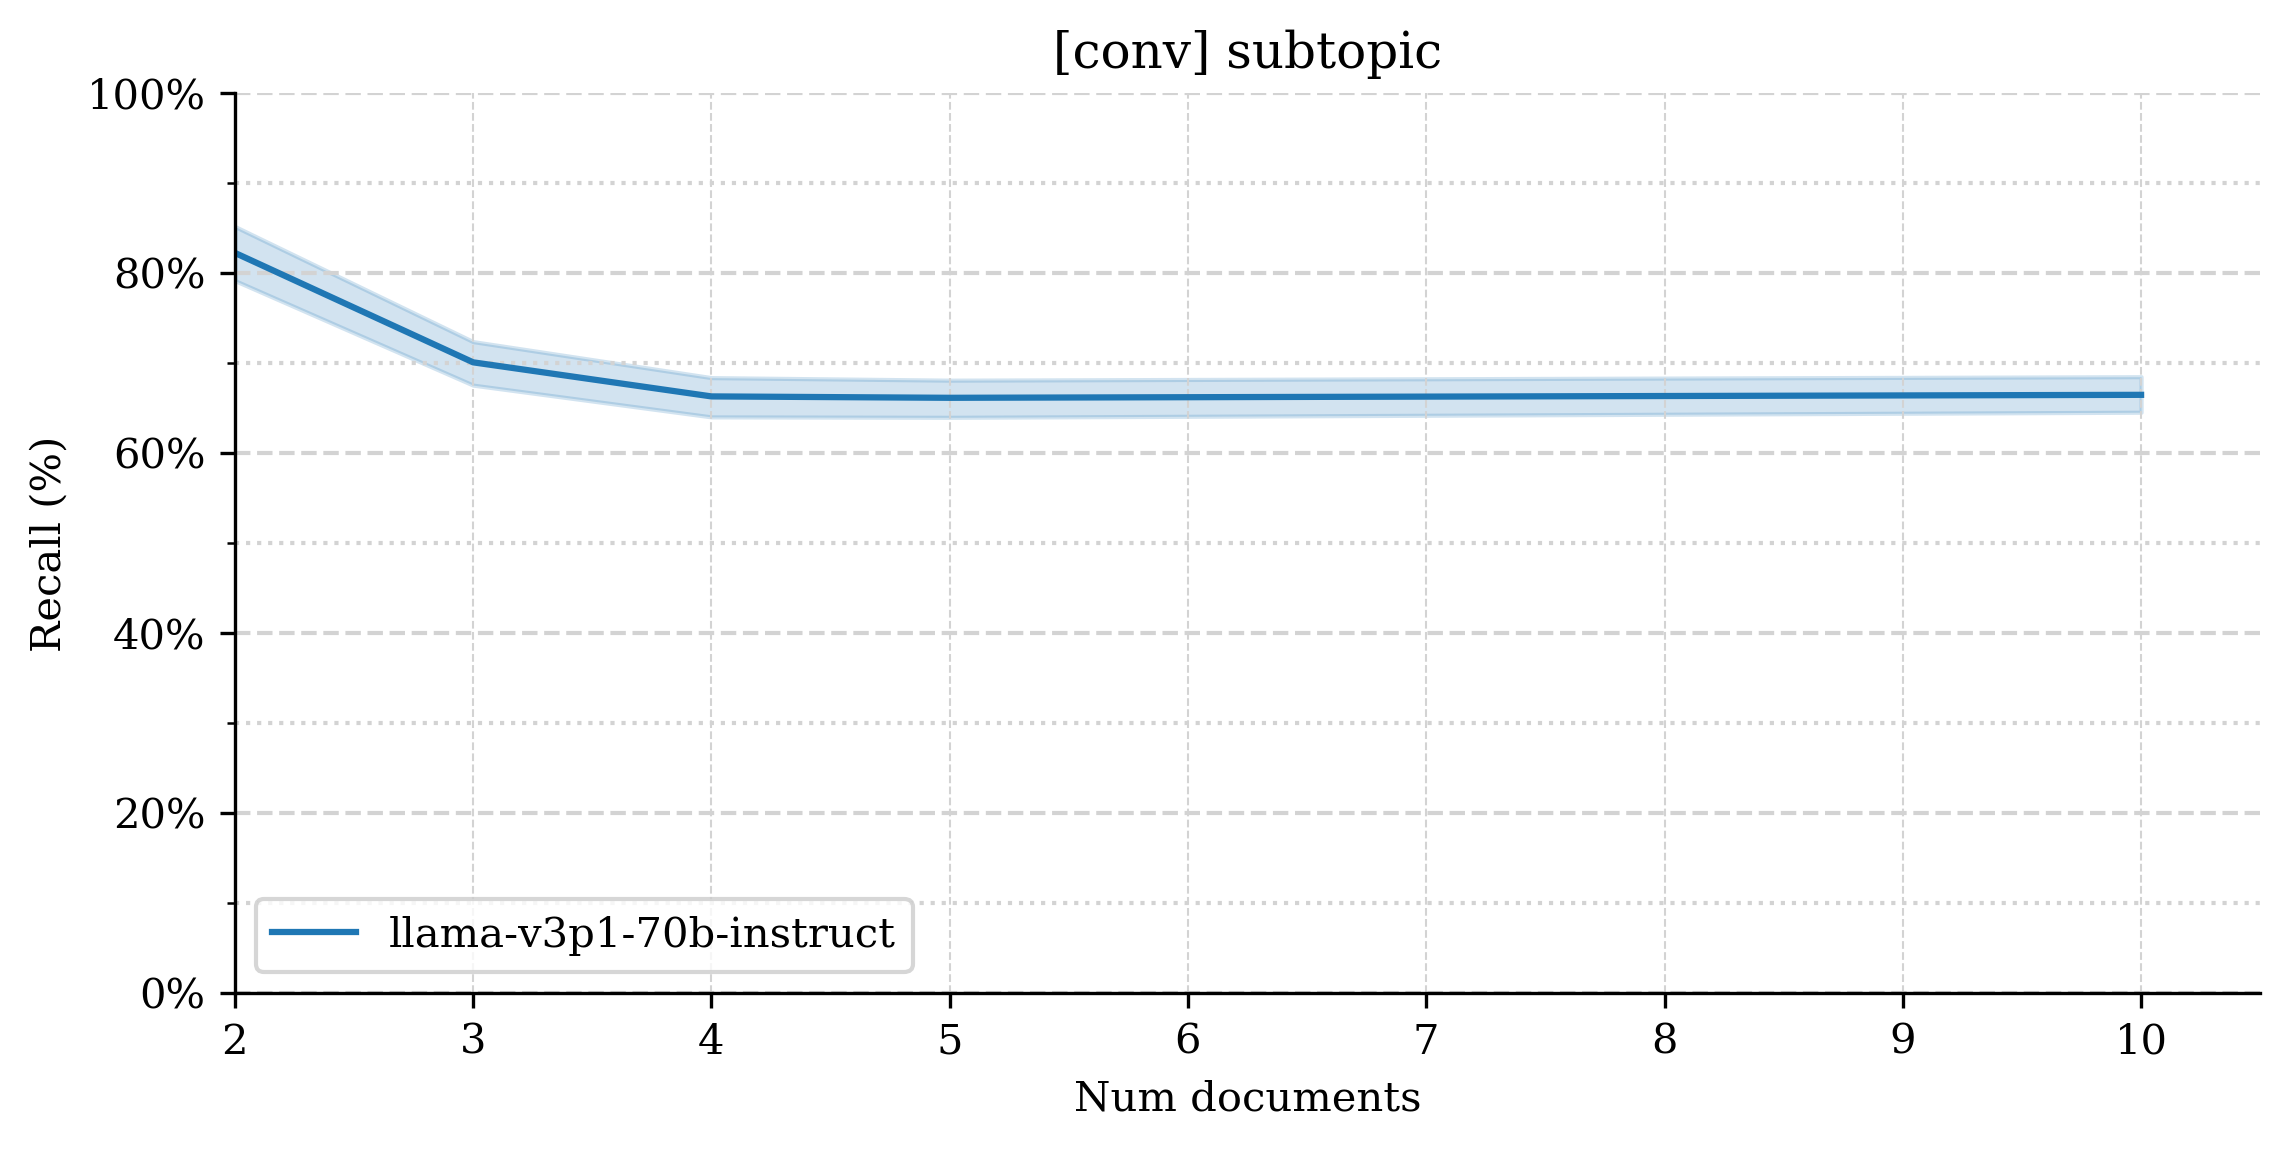

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(FULL_WIDTH, 3), dpi=300)
subset = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc")
    & (all_recall_results["summarizer_model"] == "llama-v3p1-70b-instruct")
    & (all_recall_results["prompt"] == "subtopic")
]
ax.set_title(f"[{domain}] subtopic")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model")

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")


ax.set_xlabel("Num documents")
ax.set_ylabel("Recall (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.5))

remove_axes(ax)
adjust(fig)
ax.legend(loc="lower left", ncols=1, bbox_to_anchor=(0.0, 0.0), fontsize=10)
save_fig(fig, f"{domain}/{metric}/lineplot/recall/subtopic__fc+pc__llama3.1__{max_rank}.png", dpi=300)

Image saved in ../paper-oct/images/conv__bidirectional__lineplot__recall__subtopic_trustworthy__fc+pc__all_models__None.png


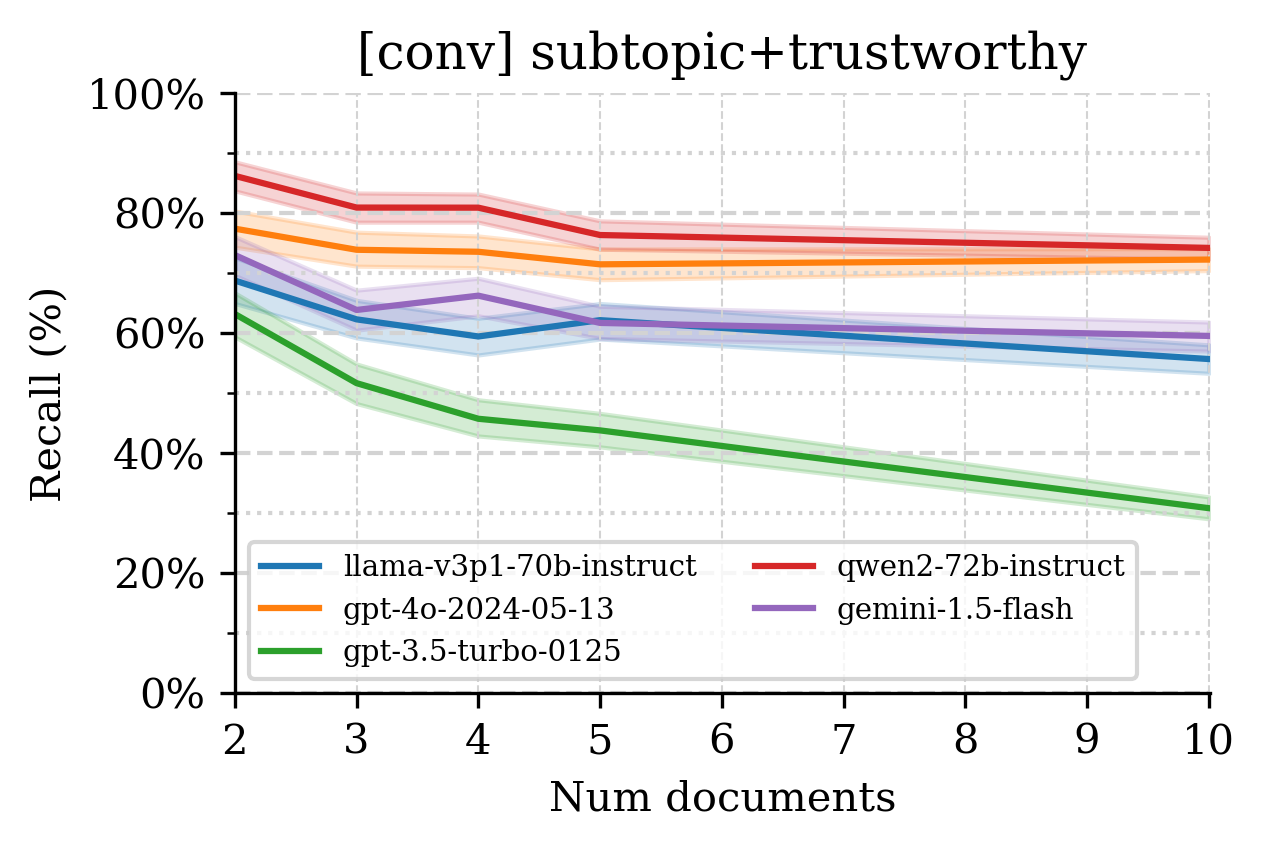

In [126]:
prompt_type = "subtopic_trustworthy"

fig, ax = plt.subplots(1, 1, figsize=(COL_WIDTH, 2), dpi=300)

subset = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc")
    & (all_recall_results["prompt"] == prompt_type)
]

ax.set_title(f"[{domain}] {prompt_type.replace("_", "+")}")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model")

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")


ax.set_xlabel("Num documents")
ax.set_ylabel("Recall (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.01))
remove_axes(ax)
adjust(fig)
ax.legend(loc="lower left", ncols=2, bbox_to_anchor=(0.0, 0.0), fontsize=7)
save_fig(fig, f"{domain}__{metric}__lineplot__recall__{prompt_type}__fc+pc__all_models__{max_rank}.png", dpi=300)

In [127]:
prompt_type = "subtopic_trustworthy"
print(domain, prompt_type)
subset = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc")
    & (all_recall_results["prompt"] == prompt_type)
]
subset[["num_documents","summarizer_model","fraction"]].groupby(["num_documents","summarizer_model"]).mean()

conv subtopic_trustworthy


fraction
num_documents summarizer_model                 
2             gemini-1.5-flash         0.730205
              gpt-3.5-turbo-0125       0.631965
              gpt-4o-2024-05-13        0.774194
              llama-v3p1-70b-instruct  0.687683
              qwen2-72b-instruct       0.862170
3             gemini-1.5-flash         0.638667
              gpt-3.5-turbo-0125       0.516667
              gpt-4o-2024-05-13        0.739000
              llama-v3p1-70b-instruct  0.623000
              qwen2-72b-instruct       0.809333
4             gemini-1.5-flash         0.662500
              gpt-3.5-turbo-0125       0.457333
              gpt-4o-2024-05-13        0.735667
              llama-v3p1-70b-instruct  0.594500
              qwen2-72b-instruct       0.809167
5             gemini-1.5-flash         0.617067
              gpt-3.5-turbo-0125       0.437967
              gpt-4o-2024-05-13        0.714733
              llama-v3p1-70b-instruct  0.621700
              qwen2-72b-instruct       0.763567
10            gemini-1.5-flash         0.595417
              gpt-3.5-turbo-0125       0.308333
              gpt-4o-2024-05-13        0.722667
              llama-v3p1-70b-instruct  0.556867
              qwen2-72b-instruct       0.742133

In [128]:
print(domain, prompt_type)
subset[["num_documents","summarizer_model","fraction"]].groupby(["num_documents","summarizer_model"]).mean().mean()

conv subtopic_trustworthy


fraction    0.6541
dtype: float64

In [131]:
prompt_type = "subtopic"
# prompt_type = "subtopic"
print(domain, prompt_type)
subset = all_recall_results[
    (all_recall_results["label_type"] == "fc+pc")
    & (all_recall_results["prompt"] == prompt_type)
]
print(domain, prompt_type)
_recall_subset = subset[["num_documents","summarizer_model","fraction"]].groupby(["num_documents","summarizer_model"]).mean().reset_index()
# _recall_subset = _recall_subset["summarizer_model"] != 'gpt-3.5-turbo-0125']
_recall_subset["fraction"] = _recall_subset["fraction"].apply(lambda x: x * 100)
_recall_subset_2 = _recall_subset[_recall_subset["num_documents"] == 2].set_index("summarizer_model").rename({"fraction": "fraction_baseline"}, axis=1).drop("num_documents", axis=1)
_recall_subset_all = _recall_subset.set_index("summarizer_model")
_recall_subset_all = _recall_subset_all.join(_recall_subset_2, how="left").reset_index()
_recall_subset_all["drop"] = _recall_subset_all["fraction"] - _recall_subset_all["fraction_baseline"]
_recall_subset_all.sort_values("fraction", ascending=False)#[["num_documents", "drop"]].groupby("num_documents").mean()

conv subtopic
conv subtopic


,summarizer_model,num_documents,fraction,fraction_baseline,drop
4,qwen2-72b-instruct,2,86.070381,86.070381,0.000000
2,gpt-4o-2024-05-13,2,85.337243,85.337243,0.000000
3,llama-v3p1-70b-instruct,2,82.258065,82.258065,0.000000
7,gpt-4o-2024-05-13,3,78.116667,85.337243,-7.220577
9,qwen2-72b-instruct,3,77.833333,86.070381,-8.237048
22,gpt-4o-2024-05-13,10,77.480000,85.337243,-7.857243
0,gemini-1.5-flash,2,77.272727,77.272727,0.000000
24,qwen2-72b-instruct,10,76.520000,86.070381,-9.550381
12,gpt-4o-2024-05-13,4,74.536667,85.337243,-10.800577
20,gemini-1.5-flash,10,73.144192,77.272727,-4.128535


Image saved in ../paper-oct/images/conv__bidirectional__lineplot__recall__subtopic_trustworthy__all_models__None.png


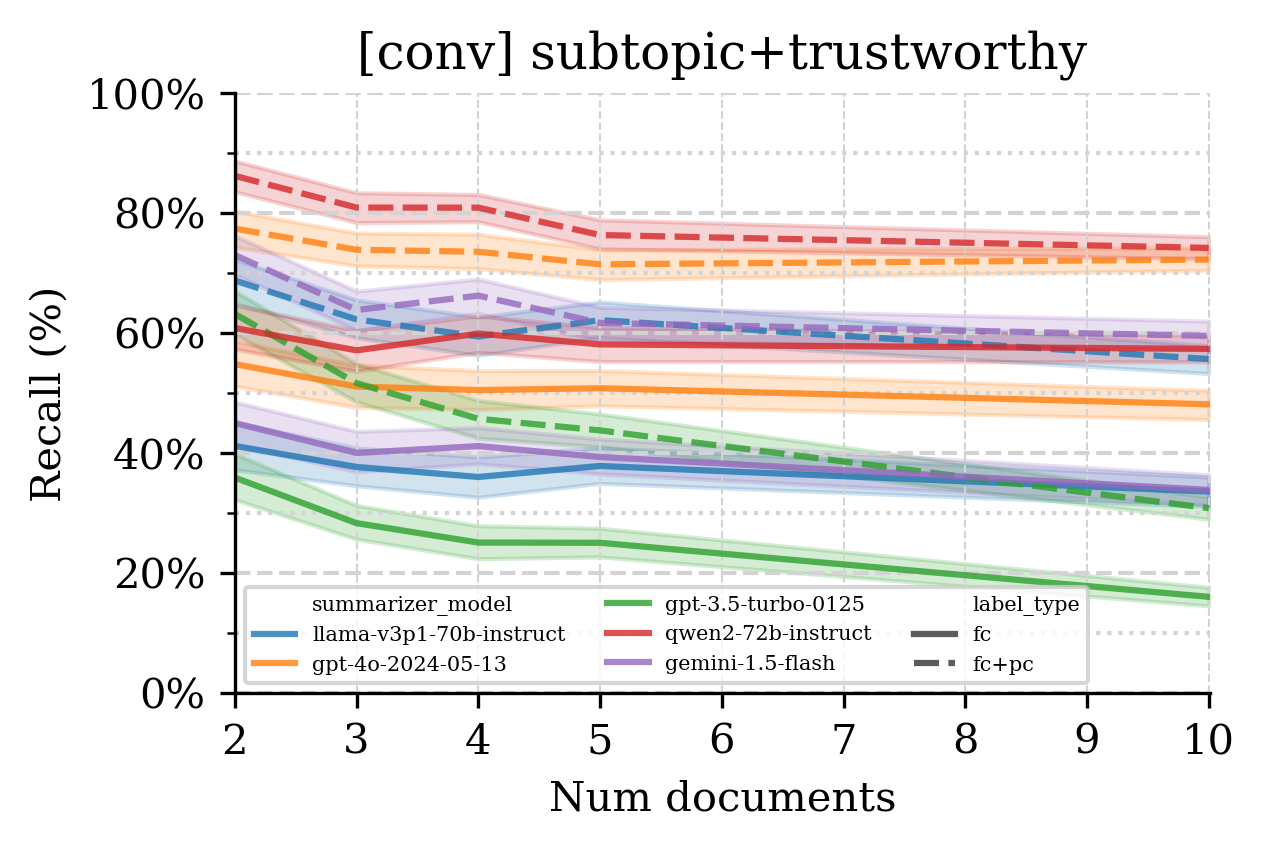

In [132]:
prompt_type = "subtopic_trustworthy"


fig, ax = plt.subplots(1, 1, figsize=(COL_WIDTH, 2), dpi=300)
subset = all_recall_results[(all_recall_results["prompt"] == prompt_type)]
ax.set_title(f"[{domain}] {prompt_type.replace("_", "+")}")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model", style="label_type", alpha=0.8)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")


ax.set_xlabel("Num documents")
ax.set_ylabel("Recall (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.01))

remove_axes(ax)
adjust(fig)
ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0.0, 0.0), fontsize=5)
save_fig(fig, f"{domain}__{metric}__lineplot__recall__{prompt_type}__all_models__{max_rank}.png", dpi=300)

## Recall: Subtopic and Subtopic Trustworthy

In [ ]:
subset = all_recall_results[(all_recall_results["label_type"] == "fc+pc")]

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)

ax = axes[0]
ax.set_title(f"[{domain}] subtopic")
subset_subtopic = subset[(subset["prompt"] == "subtopic")]
sns.lineplot(subset_subtopic, x="num_documents", y="fraction", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Recall (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.01))
ax.legend(loc="lower left", ncols=2, bbox_to_anchor=(0, 0), fontsize=7)

remove_axes(ax)

ax = axes[1]
subset_subtopic_shared = subset[(subset["prompt"] == "subtopic_trustworthy")]
ax.set_title(f"[{domain}] subtopic+trustworthy")
sns.lineplot(subset_subtopic_shared, x="num_documents", y="fraction", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Recall (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.05))
remove_axes(ax)
ax.get_legend().remove()

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}/{metric}/lineplot/recall/both_prompts__fc+pc__{max_rank}.png", dpi=300)

## Is the model more likely to get correct insights from specific documents?

In [ ]:
def compute_doc_provenance(
    data,                       
    ref_is_queried_subtopic: bool=True,
    ref_is_shared: bool=False,
    max_rank: int | str | None=None,
):
    # Label by response id
    labels_by_idx = defaultdict(list)
    for label in data:
        labels_by_idx[label["response_idx"]].append(label)
        
    # For each response, check the attribution of every ref insight
    results = defaultdict(list)
    for response_id, response_labels in labels_by_idx.items():
        ref_labels = [l for l in response_labels if l["ref_uuid"] is not None]

        # Get correct labels
        if ref_is_queried_subtopic:
            ref_labels = [l for l in ref_labels if l["ref_is_queried_subtopic"]]
        if ref_is_shared:
            ref_labels = [l for l in ref_labels if l["ref_is_shared"]]

        num_refs = len(ref_labels)
        if max_rank is not None:
            if isinstance(max_rank, int):
                ref_labels = [l for l in ref_labels if l["pred_rank"] is None or l["pred_rank"] < max_rank]
            elif max_rank == "num_refs":
                ref_labels = [l for l in ref_labels if l["pred_rank"] is None or l["pred_rank"] < num_refs]
            else:
                raise ValueError(f"Unclear value for max_rank: {max_rank}")
        
        labels_by_doc = defaultdict(list)
        for label in ref_labels:
            for doc_id in label["ref_doc_attribution"]:
                labels_by_doc[doc_id].append(label)

        for doc_id in range(0, ref_labels[0]["num_refs_in_context"]):
            results["response_id"].extend([response_id] * 2)
            results["doc_position"].extend([doc_id] * 2)
            results["label_type"].extend(["fc", "fc+pc"])
            
            n = len(labels_by_doc[doc_id])
            num_full_cov_preds = len([l for l in labels_by_doc[doc_id] if l["coverage"] == "FULL_COVERAGE"])
            num_part_cov_preds = len([l for l in labels_by_doc[doc_id] if l["coverage"] == "PARTIAL_COVERAGE"])

            results["n"].extend([n] * 2)
            results["tp"].extend([
                num_full_cov_preds,
                num_full_cov_preds + num_part_cov_preds,
            ])
            results["fraction"].extend([
                ((num_full_cov_preds) / n) if n > 0 else None,
                ((num_full_cov_preds + num_part_cov_preds) / n) if n > 0 else None,
            ])
    
    return pd.DataFrame(results)

In [ ]:
doc_provenance = []
for model in MODELS:
    for prompt in PROMPT_SETTING:
        for combination in COMBINATIONS:
            filepaths = sorted(glob.glob(f"{base_dir}/{prompt}/SummHay__combinations-{combination}/{model}/{metric}__*.json"))            
            for filepath in filepaths: 
                data = read_json(filepath)

                # Frequency of 
                doc_prov = compute_doc_provenance(data["labels"], #TODO: Debug why doc prov errs when max_rank=num refs
                                        ref_is_queried_subtopic=True,
                                        ref_is_shared=(prompt == "subtopic_trustworthy"),
                                        max_rank=max_rank) 
                
                for df in (doc_prov, ):
                    df["summarizer_model"] = model.rpartition("/")[-1]
                    df["prompt"] = prompt
                    df["num_documents"] = combination
                    df["metric"] = metric
                    df["filepath"] = filepath.rpartition(metric + "__")[-1]

                doc_provenance.append(doc_prov)

doc_provenance = pd.concat(doc_provenance)
doc_provenance = doc_provenance.dropna()
doc_provenance.head()

In [ ]:
combination = 10
subset = doc_provenance[
    (doc_provenance["label_type"] == "fc+pc")
    & (doc_provenance["num_documents"] == combination)
]

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)

ax = axes[0]
ax.set_title(f"[{domain}, N={combination}] subtopic")
subset_subtopic = subset[(subset["prompt"] == "subtopic")]
sns.lineplot(subset_subtopic, x="doc_position", y="fraction", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Recall by doc") #FIXME: Fix the name

ax.set_ylim((0.0, 1))
ax.set_xlim((0, combination - 1 + .05 ))
ax.legend(loc="lower left", ncols=2, bbox_to_anchor=(0, 0), fontsize=7)

remove_axes(ax)

ax = axes[1]
subset_subtopic_shared = subset[(subset["prompt"] == "subtopic_trustworthy")]
ax.set_title(f"[{domain}, N={combination}] subtopic+trustworthy")
sns.lineplot(subset_subtopic_shared, x="doc_position", y="fraction", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Recall by doc") # FIXME
ax.get_legend().remove()

ax.set_ylim((0.0, 1))
ax.set_xlim((0, combination - 1 + .05))
remove_axes(ax)

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}/{metric}/lineplot/recall_by_input_doc/both_prompts__fc+pc__combination-{combination}__{max_rank}.png", dpi=300)

## Error Rates



In [ ]:
prompt_type = "subtopic"

fig, ax = plt.subplots(1, 1, figsize=(COL_WIDTH, 2), dpi=300)
subset = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["summarizer_model"] == "llaama-v3p1-70b-instruct")
    & (all_err_rate_results["prompt"] == prompt_type)
]
ax.set_title(f"[{domain}] {prompt_type.replace("_", "+")}")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model")

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")


ax.set_xlabel("Num documents")
ax.set_ylabel("Error Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.5))

remove_axes(ax)
adjust(fig)
save_fig(fig, f"{domain}/{metric}/lineplot/err_rate/{prompt_type}__fc+pc__empty_frame.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(FULL_WIDTH, 3), dpi=300)
subset = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["summarizer_model"] == "llama-v3p1-70b-instruct")
    & (all_err_rate_results["prompt"] == "subtopic")
]

ax.set_title(f"[{domain}] subtopic")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model")

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")


ax.set_xlabel("Num documents")
ax.set_ylabel("Error Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.5))

remove_axes(ax)
adjust(fig)
save_fig(fig, f"{domain}/{metric}/lineplot/err_rate/subtopic__fc+pc__llama3.1_only__{max_rank}.png", dpi=300)

In [ ]:
prompt_type = "subtopic_trustworthy"

fig, ax = plt.subplots(1, 1, figsize=(COL_WIDTH, 2), dpi=300)
subset = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == prompt_type)
]
ax.set_title(f"[{domain}] {prompt_type.replace("_", "+")}")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model")

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Error Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.01))
ax.legend(loc="upper left", ncols=2, bbox_to_anchor=(0, 1), fontsize=7)

remove_axes(ax)
adjust(fig)
save_fig(fig, f"{domain}/{metric}/lineplot/err_rate/{prompt_type}__fc+pc__all_models__{max_rank}.png", dpi=300)

In [ ]:
print(domain, prompt_type)
_err_subset = subset[["num_documents","summarizer_model","fraction"]].groupby(["num_documents","summarizer_model"]).mean()
_err_subset

In [ ]:
print(domain, prompt_type)
_err_subset = subset[["num_documents","summarizer_model","fraction"]].groupby(["num_documents","summarizer_model"]).mean().reset_index()
# _err_subset = _err_subset["summarizer_model"] != 'gpt-3.5-turbo-0125']
_err_subset["fraction"] = _err_subset["fraction"].apply(lambda x: x * 100)
_err_subset_2 = _err_subset[_err_subset["num_documents"] == 2].set_index("summarizer_model").rename({"fraction": "fraction_baseline"}, axis=1).drop("num_documents", axis=1)
_err_subset_all = _err_subset.set_index("summarizer_model")
_err_subset_all = _err_subset_all.join(_err_subset_2, how="left").reset_index()
_err_subset_all["drop"] = _err_subset_all["fraction"] - _err_subset_all["fraction_baseline"]
_err_subset_all[["num_documents", "drop"]].groupby("num_documents").mean()

In [ ]:
print(domain, prompt_type)
subset[["num_documents","summarizer_model","fraction"]].groupby(["num_documents","summarizer_model"]).mean().mean()

In [ ]:
#### fig, ax = plt.subplots(1, 1, figsize=(COL_WIDTH, 2), dpi=300)
subset = all_err_rate_results[(all_err_rate_results["prompt"] == "subtopic")]
ax.set_title(f"[{domain}] subtopic")
sns.lineplot(subset, x="num_documents", y="fraction", hue="summarizer_model", style="label_type", alpha=0.8)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))


ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")


ax.set_xlabel("Num documents")
ax.set_ylabel("Error Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.05))

remove_axes(ax)
adjust(fig)
ax.legend(loc="lower left", ncols=2, bbox_to_anchor=(0.0, 00), fontsize=7)
save_fig(fig, f"{domain}/{metric}/lineplot/err_rate/subtopic__all_models_label_type__{max_rank}.png", dpi=300)

### Hallucination rate: Subtopic & Subtopic+trust

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)

ax = axes[0]
subset_subtopic = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == "subtopic")
]
ax.set_title(f"[{domain}] subtopic")
sns.lineplot(subset_subtopic, x="num_documents", y="fraction", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Error Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.01))
remove_axes(ax)
ax.legend(loc="upper left", ncols=2, bbox_to_anchor=(0, 1), fontsize=7)

ax = axes[1]
subset_subtopic_shared = all_err_rate_results[
    (all_err_rate_results["label_type"] == "fc+pc")
    & (all_err_rate_results["prompt"] == "subtopic_trustworthy")
]
ax.set_title(f"[{domain}] subtopic+trustworthy")
sns.lineplot(subset_subtopic_shared, x="num_documents", y="fraction", hue="summarizer_model", ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.10))
ax.yaxis.set_major_locator(MultipleLocator(0.20))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(axis='x', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="major", linewidth=1, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=1, linestyle=':', color="lightgray")

ax.set_xlabel("Num documents")
ax.set_ylabel("Error Rate (%)")

ax.set_ylim((0.0, 1))
ax.set_xlim((2, 10.01))
remove_axes(ax)
ax.get_legend().remove()

adjust(fig, wspace=0.05)
save_fig(fig, f"{domain}/{metric}/lineplot/err_rate/both_prompts__fc+pc__{max_rank}.png", dpi=300)

In [ ]:
subset_subtopic_shared.groupby(["summarizer_model", "num_documents", "fraction"]).count()

In [ ]:
# qwen (news) subtopic+trust
# n_docs: 2 ==> 0: 31.4,  0.5: 47.4, 1: 21.2
# n_docs: 3 ==> 0: 35.2,  0.5: 48.8, 1: 16.0
# n_docs: 4 ==> 0: 38.2,  0.5: 47.8, 1: 14.0
# n_docs: 5 ==> 0: 43.4,  0.5: 45.6, 1: 11.0
# n_docs: 10 ==> 0: 67.0, 0.5: 30.0, 1:  3.0